In [1]:
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import seaborn as sns

In [2]:
# pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# pd.set_option('display.width', )
pd.set_option('display.max_colwidth', None)

# set matplotlib style
# plt.style.use('seaborn-whitegrid')
# set font styles and size
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 12

# set seaborn style
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

# set seaborn color palette
sns.set_palette('colorblind')

In [3]:
name_map = {
    # 'llama_2_7b_hf_mono_merged': 'Mono',
    'llama_2_7b_hf_ml1_merged': 'Llama-2 Mono',
    'llama_2_7b_hf_ml2_merged': 'Llama-2 Multi-2',
    'llama_2_7b_hf_ml3_merged': 'Llama-2 Multi-3',
    'llama_2_7b_hf_ml4_merged': 'Llama-2 Multi-4',
    'llama_2_7b_hf_ml5_merged': 'Llama-2 Multi-5',
    'llama_2_7b_hf_ml6_merged': 'Llama-2 Multi-6',
    # 'llama_2_7b_hf_en_merged': 'Multi-6/en',
    'llama_2_7b_hf_es_merged': 'Llama-2 Multi-6/es',
    'llama_2_7b_hf_ru_merged': 'Llama-2 Multi-6/ru',
    'llama_2_7b_hf_de_merged': 'Llama-2 Multi-6/de',
    'llama_2_7b_hf_zh_merged': 'Llama-2 Multi-6/zh',
    'llama_2_7b_hf_fr_merged': 'Llama-2 Multi-6/fr',
    'llama_2_7b_hf_ca_merged': 'Llama-2 Multi-6/ca',
    'llama_2_7b_hf_mt_es_merged': 'Llama-2 MT Multi-6/es', # translated training data
    'llama_2_7b_hf_mt_ru_merged': 'Llama-2 MT Multi-6/ru', # translated training data
    'llama_2_7b_hf_mt_de_merged': 'Llama-2 MT Multi-6/de', # translated training data
    'llama_2_7b_hf_mt_zh_merged': 'Llama-2 MT Multi-6/zh', # translated training data
    'llama_2_7b_hf_mtol_de_merged': 'Llama-2 MTOL Multi-6/de', # translated training data
    'llama_2_7b_hf_mtol_ca_merged': 'Llama-2 MTOL Multi-6/ca', # translated training data
    'llama_2_7b_hf_mt_ml2_n50_merged': 'Llama-2 MT Multi-2 N=50', # translated training data: ablation 4 (fixed ML2, NE=50)
    'llama_2_7b_hf_mt_ml2_n100_merged': 'Llama-2 MT Multi-2 N=100', # translated training data: ablation 4 (fixed ML2, NE=100)
    'llama_2_7b_hf_mt_ml2_merged': 'Llama-2 MT Multi-2', # translated training data / ablation 4 (fixed ML2, NE=200)
    'llama_2_7b_hf_mt_ml2_n300_merged': 'Llama-2 MT Multi-2 N=300', # translated training data: ablation 4 (fixed ML2, NE=300)
    'llama_2_7b_hf_mt_ml2_n400_merged': 'Llama-2 MT Multi-2 N=400', # translated training data: ablation 4 (fixed ML2, NE=400)
    'llama_2_7b_hf_mt_ml2_n1000_merged': 'Llama-2 MT Multi-2 N=1000', # translated training data: ablation 4 (fixed ML2, NE=1000)
    'llama_2_7b_hf_mt_ml3_n5_merged': 'Llama-2 MT Multi-3 N=5', # translated training data: ablation 1 (fixed ML3, NE=10)
    'llama_2_7b_hf_mt_ml3_n10_merged': 'Llama-2 MT Multi-3 N=10', # translated training data: ablation 1 (fixed ML3, NE=20)
    'llama_2_7b_hf_mt_ml3_n25_merged': 'Llama-2 MT Multi-3 N=25', # translated training data: ablation 1 (fixed ML3, NE=50)
    'llama_2_7b_hf_mt_ml3_n50_merged': 'Llama-2 MT Multi-3 N=50', # translated training data: ablation 1 (fixed ML3, NE=100)
    'llama_2_7b_hf_mt_ml3_n100_merged': 'Llama-2 MT Multi-3 N=100', # translated training data: ablation 1 (fixed ML3, NE=200)
    'llama_2_7b_hf_mt_ml3_n500_merged': 'Llama-2 MT Multi-3 N=500', # translated training data: ablation 3 (incremental ML, NE=1000)
    'llama_2_7b_hf_mt_ml3_merged': 'Llama-2 MT Multi-3', # translated training data / ablation 1 (fixed ML3, NE=400) / ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_mt_ml4_merged': 'Llama-2 MT Multi-4', # translated training data
    'llama_2_7b_hf_mt_ml4_n133_merged': 'Llama-2 MT Multi-4 N=133', # translated training data: ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_mt_ml4_n333_merged': 'Llama-2 MT Multi-4 N=333', # translated training data: ablation 3 (incremental ML, NE=1000)
    'llama_2_7b_hf_mt_ml5_merged': 'Llama-2 MT Multi-5', # translated training data
    'llama_2_7b_hf_mt_ml5_n100_merged': 'Llama-2 MT Multi-5 N=100', # translated training data: ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_mt_ml5_n250_merged': 'Llama-2 MT Multi-5 N=250', # translated training data: ablation 3 (incremental ML, NE=1000)
    'llama_2_7b_hf_mt_ml6_merged': 'Llama-2 MT Multi-6', # translated training data
    'llama_2_7b_hf_mt_ml6_n80_merged': 'Llama-2 MT Multi-6 N=80', # translated training data: ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_guanaco_merged': 'Llama-2 Multi-Guanaco',
    'Llama-2-7b-hf': 'Llama-2 Base',
    'falcon_7b_ml1_merged': 'Falcon Mono',
    'falcon_7b_ml2_merged': 'Falcon Multi-2',
    'falcon_7b_ml3_merged': 'Falcon Multi-3',
    'falcon_7b_ml4_merged': 'Falcon Multi-4',
    'falcon_7b_ml5_merged': 'Falcon Multi-5',
    'falcon_7b_ml6_merged': 'Falcon Multi-6',
    'falcon_7b_es_merged': 'Falcon Multi-6/es',
    'falcon_7b_ru_merged': 'Falcon Multi-6/ru',
    'falcon_7b_de_merged': 'Falcon Multi-6/de',
    'falcon_7b_zh_merged': 'Falcon Multi-6/zh',
    'falcon_7b_fr_merged': 'Falcon Multi-6/fr',
    'falcon_7b_ca_merged': 'Falcon Multi-6/ca',
    'falcon-7b': 'Falcon Base',
    'falcon_7b_guanaco_merged': 'Falcon Multi-Guanaco',
    'llama_2_70b_hf_mt_ml1_merged': 'Llama-2 70B Mono', 
    'llama_2_70b_hf_mt_ml2_merged': 'Llama-2 70B MT Multi-2', # translated training data
    'llama_2_70b_hf_mt_ml3_merged': 'Llama-2 70B MT Multi-3', # translated training data
    'llama_2_70b_hf_mt_ml4_merged': 'Llama-2 70B MT Multi-4', # translated training data
    'llama_2_70b_hf_mt_ml5_merged': 'Llama-2 70B MT Multi-5', # translated training data
    'llama_2_70b_hf_mt_ml6_merged': 'Llama-2 70B MT Multi-6', # translated training data
    'llama_2_70b_hf_guanaco_merged': 'Llama-2 70B Multi-Guanaco', # translated training data,
    'llama_3_8b_ml1_merged': 'Llama-3 Mono',
    'llama_3_8b_ml2_merged': 'Llama-3 Multi-2',
    'llama_3_8b_ml3_merged': 'Llama-3 Multi-3',
    'llama_3_8b_ml4_merged': 'Llama-3 Multi-4',
    'llama_3_8b_ml5_merged': 'Llama-3 Multi-5',
    'llama_3_8b_ml6_merged': 'Llama-3 Multi-6',
    'leo_7b_ml1_merged': 'Leo Mono',
    'leo_7b_ml2_merged': 'Leo Multi-2',
    'leo_7b_ml3_merged': 'Leo Multi-3',
    'leo_7b_ml4_merged': 'Leo Multi-4',
    'leo_7b_ml5_merged': 'Leo Multi-5',
    'leo_7b_ml6_merged': 'Leo Multi-6',
    "mixtral_8x7b_ml1_merged": "Mixtral Mono",
    "mixtral_8x7b_ml2_merged": "Mixtral Multi-2",
    "mixtral_8x7b_ml3_merged": "Mixtral Multi-3",
    "mixtral_8x7b_ml4_merged": "Mixtral Multi-4",
    "mixtral_8x7b_ml5_merged": "Mixtral Multi-5",
    "mixtral_8x7b_ml6_merged": "Mixtral Multi-6",
    'alpaca_eval_instructions_en': 'en',
    'alpaca_eval_instructions_es': 'es',
    'alpaca_eval_instructions_ru': 'ru',
    'alpaca_eval_instructions_de': 'de',
    'alpaca_eval_instructions_zh': 'zh',
    'alpaca_eval_instructions_fr': 'fr',
    'alpaca_eval_instructions_ca': 'ca',
    'alpaca_eval_instructions_sv': 'sv',
    'alpaca_eval_instructions_vi': 'vi',
    'alpaca_eval_instructions_ko': 'ko',
    'alpaca_eval_instructions_fi': 'fi',
    'alpaca_eval_instructions_hu': 'hu',
    'alpaca_eval_instructions_no': 'no',
    'alpaca_eval_instructions_bg': 'bg',
    'alpaca_eval_instructions_da': 'da',
    'alpaca_eval_instructions_is': 'is',
    'alpaca_eval_instructions_hi': 'hi',
    'alpaca_eval_instructions_el': 'el',
    'flores_devtest_en_es': 'es',
    'flores_devtest_en_ru': 'ru',
    'flores_devtest_en_de': 'de',
    'flores_devtest_en_zh': 'zh',
    'flores_devtest_en_fr': 'fr',
    'flores_devtest_en_ca': 'ca',
    'flores_devtest_en_sv': 'sv',
    'flores_devtest_en_bg': 'bg',
    'flores_devtest_en_no': 'no',
    'flores_devtest_en_da': 'da',
    'flores_devtest_en_is': 'is',
    'flores_devtest_en_hi': 'hi',
    'flores_devtest_en_el': 'el',
    # XCSQA
    'xcsqa_dev_en_en': 'en:en',
    'xcsqa_dev_en_es': 'en:es',
    'xcsqa_dev_en_ru': 'en:ru',
    'xcsqa_dev_en_de': 'en:de',
    'xcsqa_dev_en_zh': 'en:zh',
    'xcsqa_dev_en_fr': 'en:fr',
    'xcsqa_dev_en_vi': 'en:vi',
    'xcsqa_dev_en_hi': 'en:hi',
    'xcsqa_dev_es_es': 'es:es',
    'xcsqa_dev_ru_ru': 'ru:ru',
    'xcsqa_dev_de_de': 'de:de',
    'xcsqa_dev_zh_zh': 'zh:zh',
    'xcsqa_dev_fr_fr': 'fr:fr',
    'xcsqa_dev_vi_vi': 'vi:vi',
    'xcsqa_dev_hi_hi': 'hi:hi',
    # XQuAD
    'xquad_dev_en_en': 'en:en',
    'xquad_dev_en_es': 'en:es',
    'xquad_dev_es_es': 'es:es',
    'xquad_dev_en_ru': 'en:ru',
    'xquad_dev_ru_ru': 'ru:ru',
    'xquad_dev_en_de': 'en:de',
    'xquad_dev_de_de': 'de:de',
    'xquad_dev_en_zh': 'en:zh',
    'xquad_dev_zh_zh': 'zh:zh',
    'xquad_dev_en_vi': 'en:vi',
    'xquad_dev_vi_vi': 'vi:vi',
    'xquad_dev_en_hi': 'en:hi',
    'xquad_dev_hi_hi': 'hi:hi',
    'xquad_dev_en_el': 'en:el',
    'xquad_dev_el_el': 'el:el',
    'xquad_dev_en_ar': 'en:ar',
    'xquad_dev_ar_ar': 'ar:ar', 
    'xquad_dev_en_tr': 'en:tr',
    'xquad_dev_tr_tr': 'tr:tr',
    'xquad_dev_en_th': 'en:th',
    'xquad_dev_th_th': 'th:th',
}

training_langs = {
    'Mono': ['en'],
    'Multi-2': ['en', 'es'],
    'Multi-3': ['en', 'es', 'ru'],
    # 'N=5': ['en', 'es', 'ru'],
    # 'N=10': ['en', 'es', 'ru'],
    # 'N=25': ['en', 'es', 'ru'],
    # 'N=50': ['en', 'es', 'ru'],
    # 'N=100': ['en', 'es', 'ru'],
    # 'N=1000': ['en', 'es'], # 1000/1 + en
    # 'N=500': ['en', 'es', 'ru'], # 1000/2 + en
    # 'N=333': ['en', 'es', 'ru', 'de'], # 1000/3 + en
    # 'N=250': ['en', 'es', 'ru', 'de', 'zh'], # 1000/4 + en
    'Multi-4': ['en', 'es', 'ru', 'de'],
    'Multi-5': ['en', 'es', 'ru', 'de', 'zh'],
    'Multi-6': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Multi-6/de': ['en', 'es', 'ru', 'zh', 'fr', 'ca'],
    'Multi-6/fr': ['en', 'es', 'ru', 'de', 'zh', 'ca'],
    'Multi-6/zh': ['en', 'es', 'ru', 'de', 'fr', 'ca'],
    'Multi-6/es': ['en', 'ru', 'de', 'zh', 'fr', 'ca'],
    'Multi-6/ru': ['en', 'es', 'de', 'zh', 'fr', 'ca'],
    'Multi-6/ca': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Multi-Guanaco': ['es', 'en', 'ru', 'de', 'zh', 'fr', 'ca', 'th', 'pt', 'it', 'uk', 'eu', 'jp', 'pl', 'zh', 'vi', 'hu', 'gn', 'da', 'tr', 'nl', 'gl', 'mt', 'ar', 'ms', 'sc', 'nn', 'ko', 'ht', 'ar', 'id', 'ar', 'wo', 'uz', 'lv', 'jv', 'fi', 'tk', 'tg', 'sv', 'so', 'sl', 'sk', 'no', 'kk', 'ga', 'cz'],
}

resource_map = {
        'en': 'en',
        'de': 'de\n(HR)',
        'fr': 'fr\n(HR)',
        'zh': 'zh\n(HR)',
        'es': 'es\n(HR)',
        'ru': 'ru\n(HR)',
        'sv': 'sv\n(HR)',
        'vi': 'vi\n(LR)',
        'ko': 'ko\n(LR)',
        'ca': 'ca\n(LR)',
        'bg': 'bg\n(LR)',
        'hu': 'hu\n(LR)',
        'fi': 'fi\n(LR)',
        'no': 'no\n(LR)',
        'hi': 'hi\n(XLR)',
        'is': 'is\n(XLR)',
        'el': 'el\n(XLR)',
    }

def load_json(file):
    with open(file, "r", encoding='utf8') as f:
        return json.load(f)

def parse_filename(file):
    """
    data/outputs/llama_2_7b_hf_en_merged/alpaca_eval_instructions_ru-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.eval
    """
    # get test set and context, allowing for no context
    model_name = Path(file).parent.name
    parts = Path(file).stem.split('-')

    test_set = parts[0]
    context = parts[1]
    prompt = parts[2]
    seed = int(parts[3][1:])
    top_k = int(parts[4][1:])
    top_p = float(parts[5][1:])
    temp = float(parts[6][1:])
    bs = int(parts[7][1:])

    has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = None, None, None, None, None, None
    if len(parts) > 8:

        # with_en-l300-ds42-as42-source_en-system_en
        has_translation = parts[8] == 'with_en'
        n_eval_items = int(parts[-5][1:])
        data_seed = int(parts[-4][2:])
        api_seed = int(parts[-3][2:])
        eval_src = parts[-2]
        eval_tgt = parts[-1]

    return model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt

# sort models given the order in name_map
ordered_model_names = [
    v
    for k, v in name_map.items()
    if k.lower().startswith("llama") or k.lower().startswith("falcon") or k.lower().startswith("leo") or k.lower().startswith("mixtral")
]

print(ordered_model_names)
ordered_alpaca_test_sets = [v for k, v in name_map.items() if k.startswith('alpaca')]
print(ordered_alpaca_test_sets)
ordered_flores_test_sets = [v for k, v in name_map.items() if k.startswith('flores')]
print(ordered_flores_test_sets)
ordered_xcsr_test_sets = [v for k, v in name_map.items() if k.startswith('xcsqa')]
print(ordered_xcsr_test_sets)
ordered_xquad_test_sets = [v for k, v in name_map.items() if k.startswith('xquad')]
print(ordered_xquad_test_sets)

def apply_sort(df, ordered_test_sets, ordered_model_names=ordered_model_names):

    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df['test_set'] = pd.Categorical(df['test_set'], ordered_test_sets)

    if 'seed' in df.columns:
        df = df.sort_values(by=['model_name', 'test_set', 'seed'])
    else:
        df = df.sort_values(by=['model_name', 'test_set'])

    # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    df['test_set'] = df['test_set'].astype(str)
        
    df = df.reset_index(drop=True)

    df.info()
    
    return df

['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/de', 'Llama-2 Multi-6/zh', 'Llama-2 Multi-6/fr', 'Llama-2 Multi-6/ca', 'Llama-2 MT Multi-6/es', 'Llama-2 MT Multi-6/ru', 'Llama-2 MT Multi-6/de', 'Llama-2 MT Multi-6/zh', 'Llama-2 MTOL Multi-6/de', 'Llama-2 MTOL Multi-6/ca', 'Llama-2 MT Multi-2 N=50', 'Llama-2 MT Multi-2 N=100', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-2 N=300', 'Llama-2 MT Multi-2 N=400', 'Llama-2 MT Multi-2 N=1000', 'Llama-2 MT Multi-3 N=5', 'Llama-2 MT Multi-3 N=10', 'Llama-2 MT Multi-3 N=25', 'Llama-2 MT Multi-3 N=50', 'Llama-2 MT Multi-3 N=100', 'Llama-2 MT Multi-3 N=500', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-4 N=133', 'Llama-2 MT Multi-4 N=333', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-5 N=100', 'Llama-2 MT Multi-5 N=250', 'Llama-2 MT Multi-6', 'Llama-2 MT Multi-6 N=80', 'Llama-2 Multi-Guanaco', 'Llama-2 Base', 'Falcon M

In [44]:

def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for eval_file in Path(results_dir).glob('*/*.eval'):
        # print(eval_file)
        df = pd.read_csv(eval_file, index_col=None)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(eval_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
        # # get generation args too
        # try:
        #     hp_file = eval_file.with_suffix(".json")
        #     hps = load_json(hp_file)
        #     eval_dict.update(hps)
        # except:
        #     pass
    
    df = pd.concat(dfs, axis=0, ignore_index=True)

    df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

    # add column for training languages
    df['training_langs'] = df.apply(lambda x: training_langs[x['model_name'].split()[-1]] if not 'N=' in x['model_name'] else training_langs[x['model_name'].split()[-2]], axis=1)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('training_langs')))
    df = df.reindex(columns=cols)

    df.info()
    
    return df

df = get_results('data/alpaca_eval_outputs')
print(len(df))
print(df.columns)
df = apply_sort(df, ordered_test_sets=ordered_alpaca_test_sets)
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_name      2513 non-null   object 
 1   test_set        2513 non-null   object 
 2   seed            2513 non-null   int64  
 3   training_langs  2513 non-null   object 
 4   lang_match      2513 non-null   float64
 5   tgt_lang        2513 non-null   float64
 6   ppl             42 non-null     float64
 7   ppl_model       42 non-null     object 
 8   n               2513 non-null   int64  
 9   file            2513 non-null   object 
 10  context         2513 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 216.1+ KB
2513
Index(['model_name', 'test_set', 'seed', 'training_langs', 'lang_match',
       'tgt_lang', 'ppl', 'ppl_model', 'n', 'file', 'context'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data c

,model_name,test_set,seed,training_langs,lang_match,tgt_lang,ppl,ppl_model,n,file,context
0,Llama-2 Mono,en,0,[en],0.944,0.964,NaN,NaN,805,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt
1,Llama-2 Mono,en,42,[en],0.933,0.954,NaN,NaN,805,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt
2,Llama-2 Mono,en,723,[en],0.938,0.960,NaN,NaN,805,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt
3,Llama-2 Mono,es,0,[en],0.436,0.450,NaN,NaN,805,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_es-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt
4,Llama-2 Mono,es,42,[en],0.451,0.467,NaN,NaN,805,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_es-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt


In [45]:
df['model_name'].unique()

array(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3',
       'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6',
       'Llama-2 MT Multi-2 N=50', 'Llama-2 MT Multi-2 N=100',
       'Llama-2 MT Multi-2', 'Llama-2 MT Multi-2 N=300',
       'Llama-2 MT Multi-2 N=400', 'Llama-2 MT Multi-2 N=1000',
       'Llama-2 MT Multi-3 N=5', 'Llama-2 MT Multi-3 N=10',
       'Llama-2 MT Multi-3 N=25', 'Llama-2 MT Multi-3 N=50',
       'Llama-2 MT Multi-3 N=100', 'Llama-2 MT Multi-3 N=500',
       'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4',
       'Llama-2 MT Multi-4 N=133', 'Llama-2 MT Multi-4 N=333',
       'Llama-2 MT Multi-5', 'Llama-2 MT Multi-5 N=100',
       'Llama-2 MT Multi-6', 'Llama-2 MT Multi-6 N=80',
       'Llama-2 Multi-Guanaco', 'Falcon Mono', 'Falcon Multi-2',
       'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5',
       'Falcon Multi-6', 'Falcon Multi-Guanaco', 'Llama-2 70B Mono',
       'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3',
       'Llama-2 70B MT Mult

In [46]:
def get_results_overview(df, cols=['model_name', 'test_set', 'seed']):
    for col in cols:
        print(f'*** {col} ***')
        print(df[col].value_counts())
        print()

get_results_overview(df)

*** model_name ***
Llama-2 Mono              54
Llama-2 70B MT Multi-5    54
Llama-2 MT Multi-5        54
Llama-2 MT Multi-6        54
Llama-2 Multi-2           54
                          ..
Falcon Multi-4            42
Falcon Multi-5            42
Falcon Multi-6            42
Falcon Multi-Guanaco      42
Mixtral Multi-3           42
Name: model_name, Length: 53, dtype: int64

*** test_set ***
en    159
es    159
hi    159
is    159
da    159
bg    159
no    159
el    159
sv    159
ca    159
fr    159
zh    159
de    159
ru    159
fi     72
hu     72
ko     72
vi     71
Name: test_set, dtype: int64

*** seed ***
0      838
42     838
723    837
Name: seed, dtype: int64



In [47]:
def get_agg_df(
        df, 
        group_cols=['model_name', 'test_set'], 
        agg_ops={
            'lang_match': [np.mean, np.std], 
            'tgt_lang': [np.mean, np.std], 
            'ppl': [np.mean, np.std],
            }
        ):
    """
    Aggregates the results of the different strategies.
    If use_macro is True, then the macro-averaged results are used, otherwise the micro-averaged results are used.
    """
    df = df.groupby(group_cols, as_index=True).agg(agg_ops)
    # df = df.reindex(['0-shot', '1-shot', 'Mem-4', 'Mem-8', 'L2M'])
    # df[df.select_dtypes(include=['number']).columns] *= 100
    df = df.round(2)
    return df

def styled_df(df, color):
    return df.style.background_gradient(axis=0, text_color_threshold=0, cmap=sns.light_palette(color, as_cmap=True)).highlight_max(axis=0, props='font-weight:bold;').format(precision=2)

# unset multi-index
# agg_df = get_agg_df(df).reset_index()
# join levels of multi-index columns
# agg_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in agg_df.columns]
# styled_df(agg_df, 'seagreen')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.984313725490196, 0.6862745098039216, 0.8941176470588236)]
bar info {<matplotlib.patches.Rectangle object at 0x7f0afc9a5f30>: {'test_set': 'en', 'model_name': 'Mono'}, <matplotlib.patches.Rectangle object at 0x7f0afc9a4370>: {'test_set': 'en', 'model_name': 'Multi-Guanaco'}, <matplotlib.patches.Rectangle object at 0x7f0afc9a7a30>: {'test_set': 'de', 'model_name': 'Mono'}, <matplotlib.patches.Rectangle object at 0x7f0afc9a4550>: {'test_set': 'de', 'model_name': 'Multi-Guanaco'}, <matplotlib.patches.Rectangle object at 0x7f0afc9a6350>: {'test_set': 'bg', 'model_name': 'Mono'}, <matplotlib.patches.Rectangle object at 0x7f0afc9a7c10>: {'test_set': 'bg', 'model_name': 'Multi-Guanaco'}, <matplotlib.patches.Rectangle object at 0x7f0afc9a4190>: {'test_set': 'is', 'model_name': 'Mono'}, <matplotlib.patches.Rectangle object at 0x7f0afc9a4c70>: {'test_set': 'is', 'model_name': 'Multi-Guanaco'}}
Rectangle(xy=(-0.4, 0), width=0.4, h

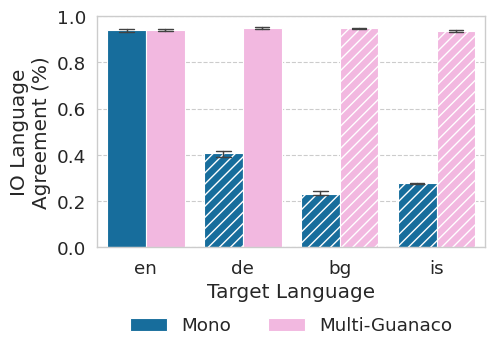

In [48]:
def make_basic_barplot_wide(df, title=None, save_path=None, make_transparent=[]):
    
    # Get the unique values for 'test_set' and 'model_name'
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()

    # number of bars to plot with hue
    expected_num_bars = len(test_sets) * len(model_names)

    width = len(test_sets)
    if len(test_sets) < 6:
        width += 1

    fig, ax = plt.subplots(figsize=(width, 3))

    # get the colors used for mono (0) and guanaco (6)
    colors = [sns.color_palette()[0], sns.color_palette()[6]]
    print(colors)

    sns.barplot(data=df,
                x='test_set', y='lang_match', 
                hue='model_name', 
                errorbar=("ci", 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                palette=colors,
                ax=ax)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    # get error bars
    errorbars = ax.lines

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    sorted_errorbars = sorted(errorbars, key=lambda bar: bar.get_xdata()[0], reverse=False)

    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    print('bar info', bar_info)
    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        print(bar, info['test_set'])
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch("///")
        else:
            bar.set_hatch('')
        
        # custom visualisation for presentation:
        
        # show only the first bar
        # if i > 0: 
        #     bar.set_alpha(0.0)
        #     errorbars[i].set_alpha(0.0)
        
        # show only the en mono bars
        # if i % 2 != 0: 
        #     print(i, bar, info['test_set'])
        #     bar.set_alpha(0.0)
        #     sorted_errorbars[i].set_alpha(0.0)            
            
    if title:
        ax.set_title(title)

    ax.set_xlabel('Target Language')
    ax.set_ylabel('IO Language\nAgreement (%)')

    # add horizontal gridlines
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.4)
    ax.set_ylim(0, 1.0)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.45
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

# plot Llama-2 models with incremental multilingual training
sdf = df[df['model_name'].isin([
    'Llama-2 Mono', 
    # 'Llama-2 Multi-6/ca', 
    'Llama-2 Multi-Guanaco'
    ])]
sdf = sdf[sdf['test_set'].isin(['en', 'de', 'bg', 'is'])]

# sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'bg', 'is', 'hi', 'el'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

make_basic_barplot_wide(
    sdf, 
    # save_path='data/plots/chat_lang_match_llama2_7b_mono_vs_guanaco.png'
    )



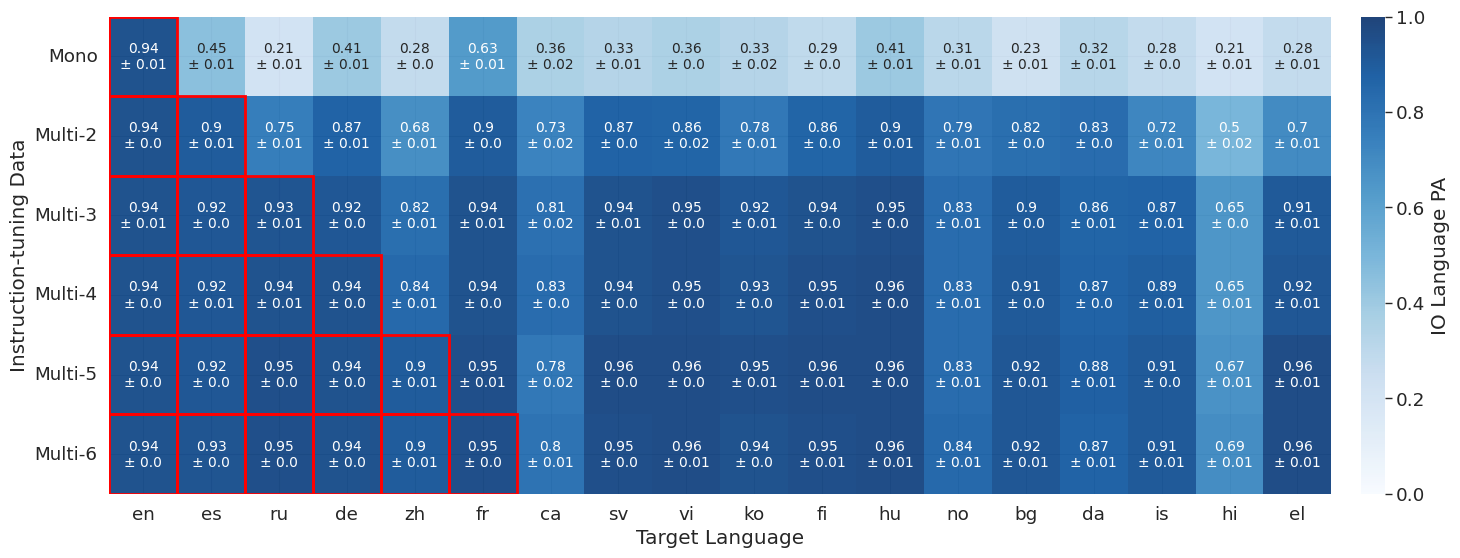

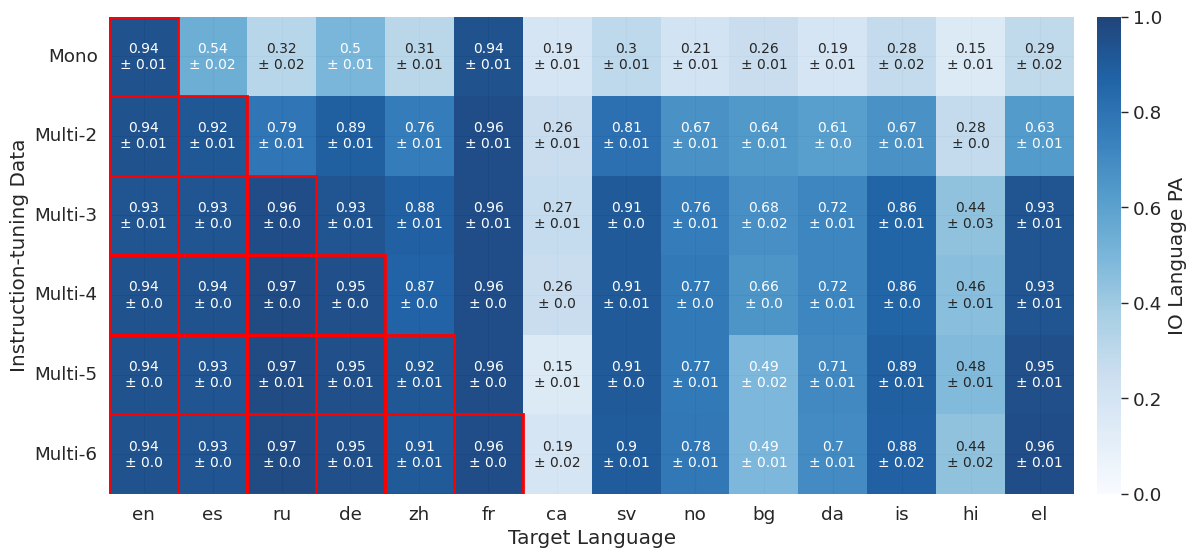

In [49]:
from matplotlib.patches import Rectangle

def make_basic_heatmap(df, metric, include_std=False, title=None, save_path=None, strip_from_model_name=None, include_hatches=False):
        
    models = df['model_name'].unique()
    test_sets = df['test_set'].unique()

    # fig, ax = plt.subplots(figsize=(df.shape[0]*0.2, df.shape[1]*0.8))
    fig, ax = plt.subplots(figsize=(len(test_sets)+1, len(models)+0.2))
    
    heatmap_mean = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_mean', sort=False)
    heatmap_std = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_std', sort=False)

    # sort by order in name_map
    heatmap_mean = heatmap_mean.reindex([n for n in ordered_model_names if n in heatmap_mean.index])
    heatmap_std = heatmap_std.reindex([n for n in ordered_model_names if n in heatmap_std.index])

    # sort columns by order in ordered_test_sets
    heatmap_mean = heatmap_mean.reindex(columns=[l for l in ordered_alpaca_test_sets if l in heatmap_mean.columns])
    heatmap_std = heatmap_std.reindex(columns=[l for l in ordered_alpaca_test_sets if l in heatmap_std.columns])

    if strip_from_model_name is not None:
        for segment in strip_from_model_name:
            heatmap_mean.index = heatmap_mean.index.str.replace(segment, '')
            heatmap_std.index = heatmap_std.index.str.replace(segment, '')

    if include_std:
        annotations = heatmap_mean.round(2).astype(str) + "\n± " + heatmap_std.round(2).astype(str)
    else:
        annotations = heatmap_std.round(2).astype(str)

    ax = sns.heatmap(
        heatmap_mean, annot=annotations, fmt='', 
        cmap='Blues', alpha=0.9, cbar=True, 
        cbar_kws={'label': f'IO Language PA', 
                #   'orientation': 'horizontal', 
                  'pad': 0.02,
                  }, 
        vmin=0, vmax=1.0, ax=ax
        )


    highlight_color = 'red'
    if include_hatches:
        # Get the x and y axis labels
        x_labels = heatmap_mean.columns.values
        y_labels = heatmap_mean.index.values

        # Iterate over the cells based on some condition
        for y in range(heatmap_mean.shape[0]):  # for each row
            for x in range(heatmap_mean.shape[1]):  # for each column
                # Check if the cell meets your condition to have hatches
                # Replace 'your_condition' with the actual condition
                if x_labels[x].strip('*') in training_langs[y_labels[y].split()[-1]]:
                    # Add a rectangle with the desired hatch pattern
                    # ax.add_patch(Rectangle((x, y), 1, 1, fill=False, hatch='O.', snap=False))
                    ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor=highlight_color, lw=2))

        
    # reduce font size of annotations
    for t in ax.texts:
        t.set_fontsize(10)
    
    if title:
        ax.set_title(title)

    ax.set_ylabel('Instruction-tuning Data')
    ax.set_xlabel('Target Language')

    # ensure yaxis labels are horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6'])]
# sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is', 'hi', 'el'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    # save_path='data/plots/chat_lang_match_heatmap_llama2_7b_incremental.png',
    strip_from_model_name=['Llama-2 '],
    include_hatches=True
    )


sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6'])]
# sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is', 'hi', 'el'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    # save_path='data/plots/chat_lang_match_heatmap_falcon_incremental.png',
    strip_from_model_name=['Falcon '],
    include_hatches=True
    )

# LLM Judge Results

In [89]:
def get_llm_judge_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for llm_eval_file in sorted(Path(results_dir).glob('*/*/*.jsonl')):
        # print(llm_eval_file)
        df = pd.read_json(llm_eval_file, lines=True)

        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(llm_eval_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        df['n_eval_items'] = n_eval_items
        df['data_seed'] = data_seed
        df['api_seed'] = api_seed
        df['eval_src'] = eval_src
        df['eval_tgt'] = eval_tgt
        df['eval_model'] = llm_eval_file.parent.parent.name

        dfs.append(df)
            
    print(f'Gathered {len(dfs)} dataframes.')
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('eval_src')))
    cols.insert(4, cols.pop(cols.index('eval_tgt')))
    print(cols)
    df = df.reindex(columns=cols)

    return df

df = get_llm_judge_results('data/llm_judge/likert')
print(len(df))

# inspect rows with NaN values in eval_score
# df[df['eval_score'].isna()]
# df[df['eval_score'] == 0]

# drop rows containing isna values in eval_score
df = df.dropna(subset=['eval_score'])
print(len(df))

# drop rows where eval_score is not between 1 and 6
df = df[(df['eval_score'] >= 1) & (df['eval_score'] <= 6)]
print(len(df))

# if 'system_lang' does not match 'source_lang', then set 'eval_score' to 1
df.loc[df['system_lang'] != df['source_lang'], 'eval_score'] = 1

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

# discard column with name "eval_Should I leave him. How do I like it?" - occurs once due to parsing errors from jsonl object returned from llm
# data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_el-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source_en-system_en.jsonl
df = df.drop(columns=['eval_Should I leave him. How do I like it?'])

df = apply_sort(df, ordered_test_sets=ordered_alpaca_test_sets)

# inspect total tokens from eval_meta
eval_costs = []
for i, row in df.iterrows():
    # eval_tokens.append(row['eval_meta']['prompt_tokens'] + row['eval_meta']['completion_tokens'])
    cost = row['eval_meta'].get('cost', 0.0)
    if isinstance(row['translation_meta'], dict):
        cost += row['translation_meta']['cost']
    eval_costs.append(cost)

print(len(df))
print(len(eval_costs))
print(np.mean(eval_costs))
print(max(eval_costs))
print(min(eval_costs))
print(sum(eval_costs))

# drop columns: eval_meta, translation_meta, prompt, source, system
df = df.drop(columns=['eval_meta', 'translation_meta', 'prompt', 'source', 'system', 'source_en', 'system_en'])
len(df)

# check that for each model, the same ids are evaluated
all_ids = set()
for model_name in df['model_name'].unique():
    ids = df[df['model_name'] == model_name]['id'].unique()
    all_ids.update(ids)
print(len(all_ids))

df.info()

Gathered 2489 dataframes.
['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt', 'prompt', 'system', 'finish_reason', 'source', 'secs', 'id', 'eval_reasoning', 'eval_score', 'eval_meta', 'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed', 'api_seed', 'eval_model', 'eval_Pizzeria,', 'source_en', 'system_en', 'translation_meta', 'eval_Should I leave him. How do I like it?', 'eval_OneLove']
747205
747015
746482
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746482 entries, 0 to 746481
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   model_name        746482 non-null  object 
 1   test_set          746482 non-null  object 
 2   seed              746482 non-null  int64  
 3   eval_src          746482 non-null  object 
 4   eval_tgt          746482 non-null  object 
 5   prompt            746482 non-null  object 
 6   system            746482 non-null  object 
 7   finish_reason     

In [90]:
print(df['model_name'].value_counts())
print(df['eval_src'].value_counts())
print(df['eval_tgt'].value_counts())
print(df['eval_score'].value_counts())
print(df['test_set'].value_counts())
print(df['id'].value_counts())
print(df['eval_model'].value_counts())

Llama-2 Multi-2             74684
Llama-2 Multi-6             46462
Llama-2 Multi-Guanaco       30593
Llama-2 Multi-5             30588
Llama-2 Mono                30586
                            ...  
Llama-2 MT Multi-4 N=133     2696
Llama-2 MT Multi-3 N=500     2696
Llama-2 MT Multi-2 N=50      2693
Llama-2 MT Multi-2 N=400     2693
Llama-2 MT Multi-4 N=333     1795
Name: model_name, Length: 53, dtype: int64
source       703303
source_en     43179
Name: eval_src, dtype: int64
system       703303
system_en     43179
Name: eval_tgt, dtype: int64
1.0    293151
4.0    132598
3.0    103596
2.0     88188
5.0     77923
6.0     51026
Name: eval_score, dtype: int64
de    58762
zh    57825
ru    56920
fr    48861
es    48553
no    44072
is    44065
bg    44061
sv    44056
hi    44052
el    44048
ca    43155
en    41657
hu    32272
fi    31482
ko    31449
vi    31192
Name: test_set, dtype: int64
56     2489
795    2489
447    2489
118    2489
260    2489
       ... 
262       1
261       1
2

In [91]:
df.head()

,model_name,test_set,seed,eval_src,eval_tgt,finish_reason,secs,id,eval_reasoning,eval_score,source_lang,system_lang,context,n_eval_items,data_seed,api_seed,eval_model,"eval_Pizzeria,",eval_OneLove
0,Llama-2 Mono,en,0,source,system,stop,0.793132,192,"The submission provides a clear and complete answer to the question by explaining the relationship between warmth and sleepiness through the body's internal temperature regulation. It discusses the release of chemicals such as histamine and serotonin, which cause drowsiness and fatigue, and explains the body's thermoregulatory system. Additionally, it acknowledges individual sleep needs and environmental factors that can affect sleep quality. The response lacks explicit headings, bullet points, or numbered lists to break up the information and make it easier to read, but it is logically organized and easy to follow. Therefore, it meets the '5' rating for being very helpful.",5.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN,NaN
1,Llama-2 Mono,en,0,source,system,stop,1.108659,718,"The submission provides a clear and complete answer to the task by defining what 'keeping a promise' means for kids. It explains the concept in detail, highlighting how it involves small and large commitments, the development of responsibility and accountability, and the building of trust and relationships. The response is relevant, clear, and complete, meeting the requirements of the criterion.",6.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN,NaN
2,Llama-2 Mono,en,0,source,system,stop,2.605155,168,"The submission provides a clear and complete answer to the question, without any additional information or explanations. It directly addresses the question and does not lack detail or explanation. However, it does not offer additional information or explanations that would be useful or insightful to the user. Therefore, it meets the criteria for 'Moderately helpful' (3).",3.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN,NaN
3,Llama-2 Mono,en,0,source,system,stop,1.376305,522,"The submission is relevant to the task as it crafts a story from the given facts and scenarios. It provides a clear and complete answer, detailing the campaign, the teams' actions, and the success of the initiative. However, the response could be more concise and organized for greater clarity.",4.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN,NaN
4,Llama-2 Mono,en,0,source,system,stop,0.841068,536,"The submission provides a clear and complete answer to the user's question by suggesting relevant hashtags related to the post. It offers additional information that is useful for the user's needs. However, the response lacks a structured format such as headings, bullet points, or numbered lists to break up the information and make it easier to read.",5.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN,NaN


In [92]:
# set pandas settings to display more rows
pd.set_option('display.max_rows', 50)
df['model_name'].value_counts()

Llama-2 Multi-2             74684
Llama-2 Multi-6             46462
Llama-2 Multi-Guanaco       30593
Llama-2 Multi-5             30588
Llama-2 Mono                30586
                            ...  
Llama-2 MT Multi-4 N=133     2696
Llama-2 MT Multi-3 N=500     2696
Llama-2 MT Multi-2 N=50      2693
Llama-2 MT Multi-2 N=400     2693
Llama-2 MT Multi-4 N=333     1795
Name: model_name, Length: 53, dtype: int64

In [93]:


def plot_llm_judge_score_distribution(df, title=None, save_path=None, presentation_models=None, presentation_test_sets=None, use_resource_map=False):

    # for each test set, plot the distribution of eval_score for each model
    # if presentation:
    #     fig, ax = plt.subplots(figsize=(15, 5))
    # else:
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.3,
                # errorbar='sd', capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                width=0.8,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]
    errorbars = ax.lines

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    sorted_errorbars = sorted(errorbars, key=lambda bar: bar.get_xdata()[0], reverse=False)

    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
            # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            # print(test_set)
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch("///")
        else:
            bar.set_hatch('')

        if presentation_models:
            if info['model_name'] not in model_names[:presentation_models]:
                bar.set_alpha(0.0)
                sorted_errorbars[i].set_alpha(0.0)
        
        if presentation_test_sets:
            if info['test_set'] not in test_sets[:presentation_test_sets]:
                bar.set_alpha(0.0)
                sorted_errorbars[i].set_alpha(0.0)
        
    # rename x-axis labels to resource_map
    if use_resource_map:
        ax.set_xticks([i for i in range(len(test_sets))])
        ax.set_xticklabels([resource_map[l] for l in test_sets])
        # pad the x-axis label 
        ax.set_xlabel('Target Language', labelpad=12)
        y_offset = -0.65
    else:
        ax.set_xlabel('Target Language')
        y_offset = -0.45

    ax.set_ylabel('Helpfulness Score')
    
    # fix ylim to 1-6
    ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    # legend at bottom
    ncols = len(model_names)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']


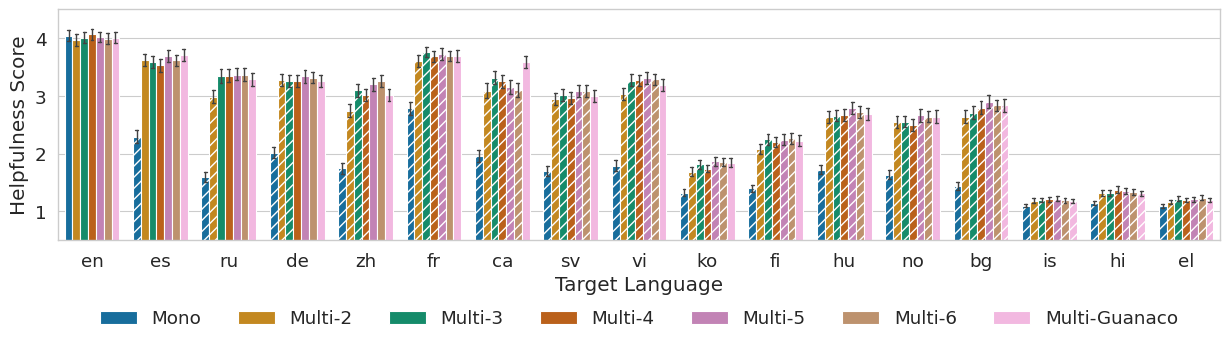

In [94]:
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-Guanaco']))]

sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# drop bg, no, is, hi, el
# sdf = sdf[sdf['test_set'].isin(['en', 'de', 'zh', 'bg', 'no', 'hi', 'is'])]


sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

plot_llm_judge_score_distribution(
    sdf, 
    # save_path=f'data/plots/chat_llm_judge_llama_7b_incremental.png',
)

# # # presentation plots
# for i in range(1, 8):
#     for j in range(1, 8):
#         plot_llm_judge_score_distribution(
#             sdf, 
#             save_path=f'data/plots/chat_llm_judge_llama_7b_incremental_m{i}_t{j}_unpenalised.png',
#             presentation_models=i,
#             presentation_test_sets=j,
#             use_resource_map=True
#             )

In [56]:
# print(len(df))
# sdf = df[(df['eval_model'].str.startswith('prometheus')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-Guanaco']))]

# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# # drop bg, no, is, hi, el
# # sdf = sdf[sdf['test_set'].isin(['en', 'de', 'zh', 'bg', 'no', 'hi', 'is'])]
# print(len(sdf))

# sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# print(len(sdf))
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

# plot_llm_judge_score_distribution(
#     sdf, 
#     # save_path=f'data/plots/chat_llm_judge_llama_7b_incremental.png',
# )


In [57]:
# sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6']))]
# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.strip()
# # print(len(sdf))
# print(sdf['model_name'].value_counts())
# plot_llm_judge_score_distribution(
#     sdf, 
#     # save_path='data/plots/chat_llm_judge_llama_7b_incremental_mt.png'
#     )


In [58]:
# sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6']))]
# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]

# sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B', '').replace('MT', '').str.strip()
# # print(len(sdf))
# print(sdf['model_name'].value_counts())
# plot_llm_judge_score_distribution(
#     sdf, 
#     # save_path='data/plots/chat_llm_judge_llama_70b_incremental_mt.png'
#     )


81812
Multi-Guanaco    11696
Multi-6          11692
Multi-5          11690
Mono             11689
Multi-2          11684
Multi-3          11682
Multi-4          11679
Name: model_name, dtype: int64
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']


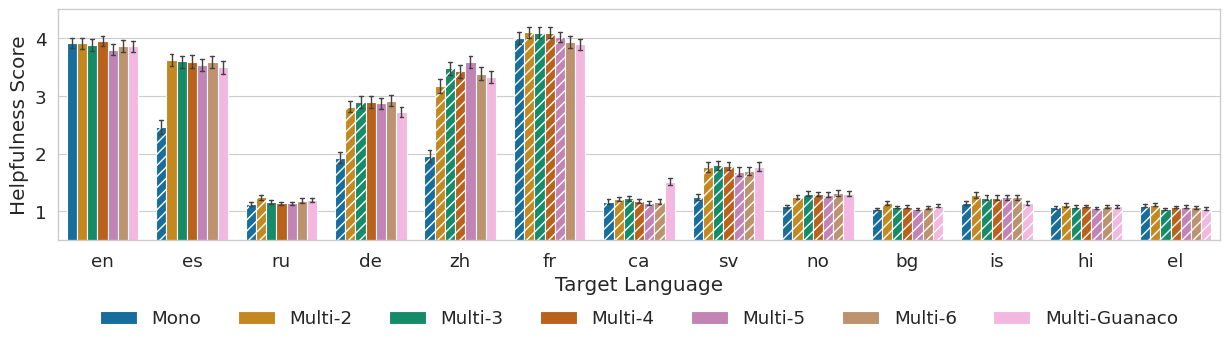

In [59]:
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6', 'Falcon Multi-Guanaco']))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.strip()
print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # save_path='data/plots/chat_llm_judge_falcon_7b_incremental.png'
    )

['Mono' 'Multi-2' 'Multi-3']


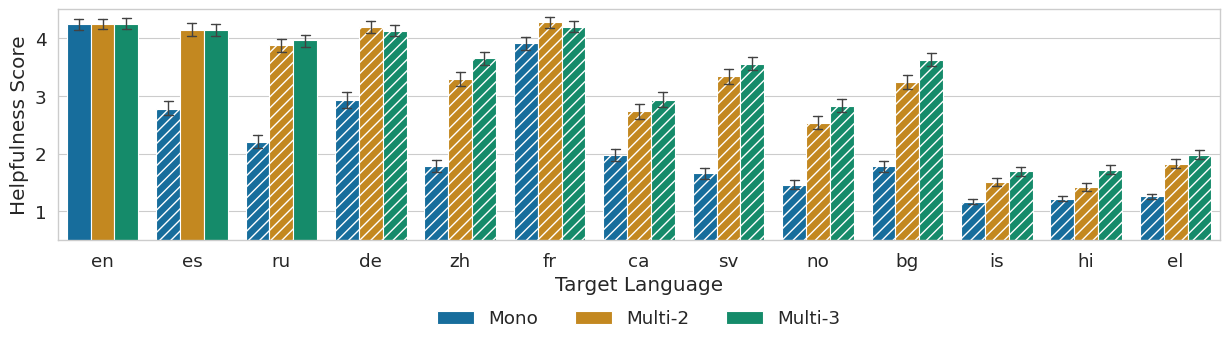

In [60]:
# Mixtral
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Mixtral Mono', 'Mixtral Multi-2', 'Mixtral Multi-3', 'Mixtral Multi-4', 'Mixtral Multi-5', 'Mixtral Multi-6']))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# drop bg, no, is, hi, el
# sdf = sdf[sdf['test_set'].isin(['en', 'de', 'zh', 'bg', 'is'])]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Mixtral ', '')

plot_llm_judge_score_distribution(
    sdf, 
    # save_path='data/plots/chat_llm_judge_mixtral_incremental.png',
    )

['Mono' 'Multi-2' 'Multi-3']


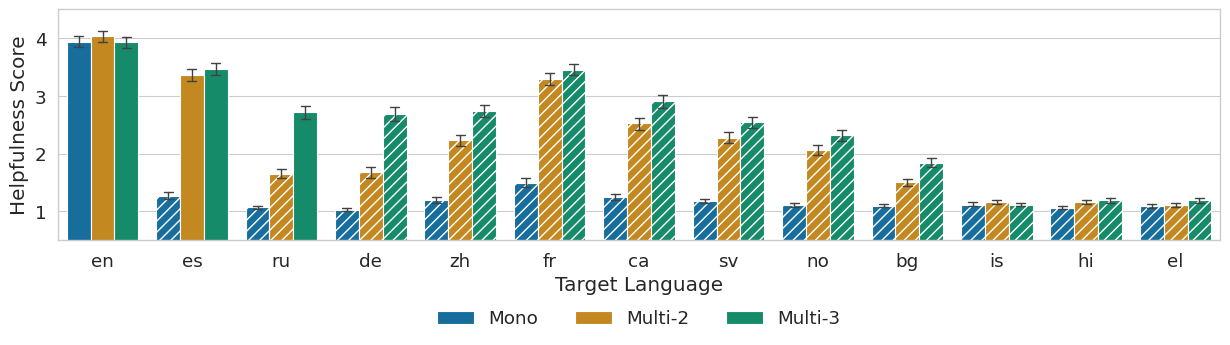

In [61]:
# leo
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Leo Mono', 'Leo Multi-2', 'Leo Multi-3', 'Leo Multi-4', 'Leo Multi-5', 'Leo Multi-6']))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# drop bg, no, is, hi, el
# sdf = sdf[sdf['test_set'].isin(['en', 'de', 'zh', 'bg', 'is'])]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Leo ', '')

plot_llm_judge_score_distribution(
    sdf, 
    # save_path='data/plots/chat_llm_judge_leo_incremental.png',
    )

['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6']


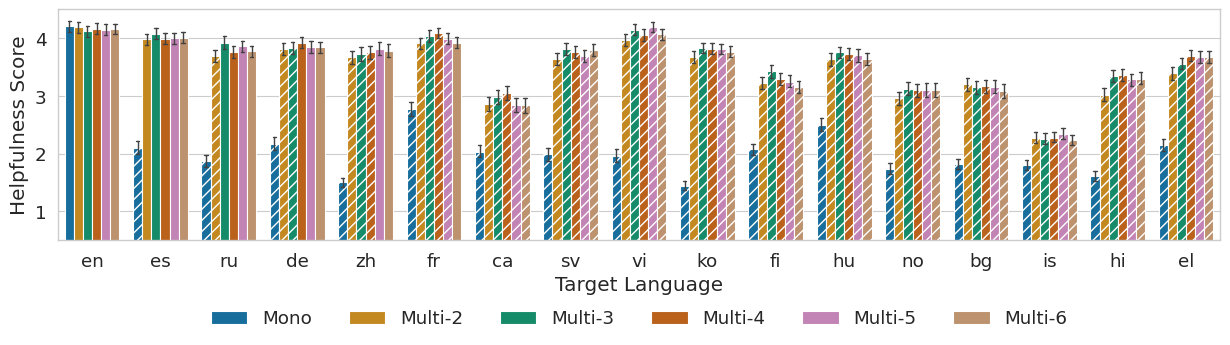

In [62]:
# llama 3
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-3 Mono', 'Llama-3 Multi-2', 'Llama-3 Multi-3', 'Llama-3 Multi-4', 'Llama-3 Multi-5', 'Llama-3 Multi-6']))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# drop bg, no, is, hi, el
# sdf = sdf[sdf['test_set'].isin(['en', 'de', 'zh', 'bg', 'is'])]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-3 ', '')

plot_llm_judge_score_distribution(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama3_8b_incremental.png',
    )

['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6']
saved to data/plots/chat_llm_judge_llama_7b_incremental_languages_n400.png
[8.5 4.5]


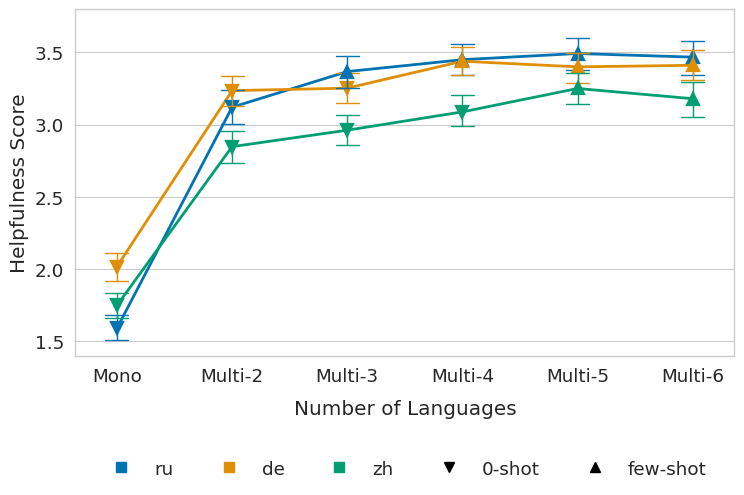

In [63]:
def plot_llm_judge_score_distribution_ablation_on_n_langs(df, title=None, xlabel=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(8.5, 4.5))
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(model_names)

    marker_styles = {
        '0-shot': 'v',
        'few-shot': '^', 
    }

    # need to explicitly define ylims to ensure correct scaling with other plots
    ax.set_ylim([1.4, 3.8])
    # ax.set_ylim([2.4, 3.8])

    # ax.set_ylim([1.3, 3.7])
    # ax.set_yticks(np.arange(1.3, 3.7, 0.3))
    # plot the lines using matplotlib
    for test_set in test_sets:
        # Extract the subset for each test set
        subset = df[df['test_set'] == test_set]
        # compute mean for each model on each test set
        subset = subset.groupby(['model_name', 'test_set'], as_index=False).mean(numeric_only=True)
        # Plot the lineplot for this subset
        ax.plot(subset['model_name'], subset['eval_score'], 
                linestyle='-', 
                marker='', 
                label=test_set, 
                linewidth=2.0, 
                color=sns.color_palette()[test_sets.index(test_set)]
                )

    # ax.set_yticks(np.arange(1.3, 3.7, 0.3))

    # Now, overlay the points with different markers for each condition
    # Iterate over each condition and plot separately
    for condition, marker in marker_styles.items():
        # Create a subset of the dataframe for the current condition
        subset = df[df['condition'] == condition]

        # Plot the pointplot for this subset
        sns.pointplot(data=subset, x='model_name', y='eval_score', hue='test_set', ax=ax,
                    errorbar=("ci", 95), capsize=0.2,
                    err_kws={"linewidth": 1.0},
                    alpha=1.0,
                    order=model_names,
                    hue_order=test_sets,
                    linestyles='',  # No lines for pointplot
                    markers=marker,  # Use the specific marker for this condition
                    markersize=8,
                    )
    
    # set yticks
    # ax.set_yticks(np.arange(1.3, 3.7, 0.3))

    # pad xlabel             
    ax.set_xlabel(xlabel, labelpad=10)
    ax.set_ylabel('Helpfulness Score')

    ax.set_title(title)

    # build custom legend
    legend = ax.get_legend() 
    legend_colors = [handle.get_color() for handle in legend.legend_handles][:len(test_sets)]
    # get labels from legend
    labels = [text.get_text() for text in legend.get_texts()][:len(test_sets)]
    
    # define proxy artists for legend
    f = lambda m,c: plt.plot([], [], marker=m, color=c, ls="none")[0]

    handles = [f("s", i) for i in legend_colors]
    handles += [f(i, "k") for i in marker_styles.values()]
    labels = labels[:len(test_sets)] + list(marker_styles.keys())
    
    # increase legend marker size
    for handle in handles:
        handle.set_markersize(7.0)

    # legend at bottom
    ncols = len(handles)
    y_offset = -0.4
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', pad_inches=0.1, dpi=300)
        print(f'saved to {save_path}')
        print(f'{fig.get_size_inches()}')

    return

# rename model_name as percentage of non-english examples
def rename_model_name(x):
    ml_count = re.search(r'Multi-([0-9])', x).group(1)
    ne_count = int(ml_count)-1

    total_ne = int(x.split("=")[1]) * ne_count

    ne_perc = (total_ne / 3200) * 100

    # round to nearest 0.5
    # ne_perc = round(ne_perc * 2) / 2
    return f'{total_ne}\n({ne_perc:.2f}%)'


# sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2 N=1000', 'Llama-2 MT Multi-3 N=500', 'Llama-2 MT Multi-4 N=333']))]
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin([
    'Llama-2 Mono', 
    'Llama-2 MT Multi-2 N=400', 
    'Llama-2 MT Multi-3', 
    'Llama-2 MT Multi-4 N=133', 
    'Llama-2 MT Multi-5 N=100',
    'Llama-2 MT Multi-6 N=80',
    ]))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[sdf['test_set'].isin(['ru', 'de', 'zh'])]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('MT', '').str.strip()
# remove N=* from model_name
sdf['model_name'] = sdf['model_name'].apply(lambda x: x.split(' ')[0])

# add conditions for different markers indicating 0-shot or few-shot
sdf['condition'] = '0-shot'
for i, row in sdf.iterrows():
    if ('Multi-3' in row['model_name'] or 'Multi-4' in row['model_name'] or 'Multi-5' in row['model_name'] or 'Multi-6' in row['model_name']) and row['test_set'] == 'ru':
        sdf.loc[i, 'condition'] = 'few-shot'
    elif ('Multi-4' in row['model_name'] or 'Multi-5' in row['model_name'] or 'Multi-6' in row['model_name']) and row['test_set'] == 'de':
        sdf.loc[i, 'condition'] = 'few-shot'
    elif ('Multi-5' in row['model_name'] or 'Multi-6' in row['model_name']) and row['test_set'] == 'zh':
        sdf.loc[i, 'condition'] = 'few-shot'

plot_llm_judge_score_distribution_ablation_on_n_langs(
    sdf, 
    xlabel='Number of Languages',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental_languages_n400.png'
)


In [64]:
# ablation study incremental ML examples for ML3

def plot_llm_judge_score_distribution_ablation_on_n_examples(df, title=None, xlabel=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(8.5, 4.5))
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(model_names)

    line_styles = {
        '0-shot': '--',
        'few-shot': '-', 
    }

    # need to explicitly define ylims to ensure correct scaling with other plots
    # ax.set_ylim([2.4, 3.8])
    ax.set_ylim([1.4, 3.8])

    
    for condition, ls in line_styles.items():
        # Create a subset of the dataframe for the current condition
        subset = df[df['condition'] == condition]

        # Plot the pointplot for this subset
        sns.pointplot(data=subset, x='model_name', y='eval_score', hue='test_set', ax=ax,  
                    errorbar=("ci", 95), capsize=0.2,
                    err_kws={"linewidth": 1.0},
                    alpha=1.0,
                    order=model_names,
                    hue_order=test_sets,
                    linestyles=ls,
                    )
        
    # pad xlabel             
    ax.set_xlabel(xlabel, labelpad=10)
    ax.set_ylabel('Helpfulness Score')

    # show yticks at 0.5 intervals
    # ax.set_yticks(np.arange(1.3, 3.7, 0.3))    

    ax.set_title(title)

    if len(df['condition'].unique()) > 1:

        # build custom legend
        legend = ax.get_legend() 
        legend_colors = [handle.get_color() for handle in legend.legend_handles][:len(test_sets)]
        # get labels from legend
        labels = [text.get_text() for text in legend.get_texts()][:len(test_sets)]
        
        # define proxy artists for legend
        f = lambda ls, c: plt.plot([], [], linestyle=ls, color=c, marker='o', linewidth=2)[0]

        handles = [f("-", i) for i in legend_colors]
        handles += [f(i, "k") for i in line_styles.values()]
        labels = labels[:len(test_sets)] + list(line_styles.keys())
        
        # increase legend marker size
        for handle in handles:
            handle.set_markersize(7.0)

        # legend at bottom
        ncols = len(handles)
        y_offset = -0.4
        ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    else:
        # legend at bottom
        ncols = len(test_sets)
        y_offset = -0.4
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', pad_inches=0.1, dpi=300)
        print(f'saved to {save_path}')

    return


100\n(3.12%)      2698
1000\n(31.25%)    2698
0\n(0.00%)        2697
50\n(1.56%)       2693
200\n(6.25%)      2693
400\n(12.50%)     2693
300\n(9.38%)         0
Name: model_name, dtype: int64
['0\n(0.00%)', '50\n(1.56%)', '100\n(3.12%)', '200\n(6.25%)', '400\n(12.50%)', '1000\n(31.25%)']
Categories (7, object): ['0\n(0.00%)', '50\n(1.56%)', '100\n(3.12%)', '200\n(6.25%)', '300\n(9.38%)', '400\n(12.50%)', '1000\n(31.25%)']
saved to data/plots/chat_llm_judge_llama_7b_incremental_examples_ml2.png


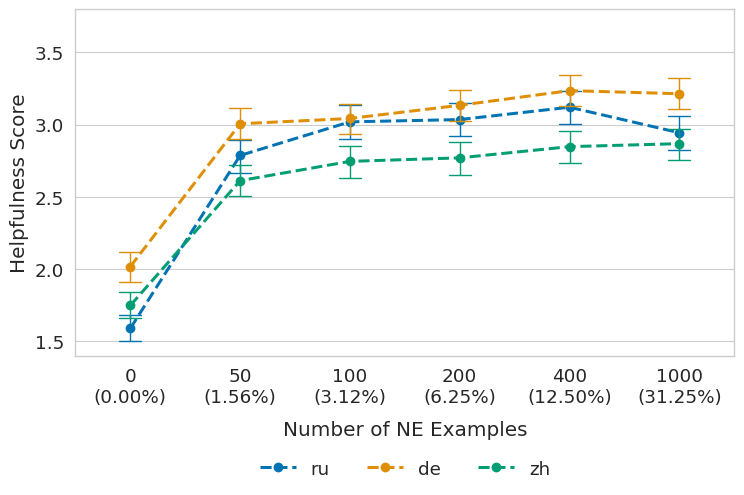

In [65]:
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin([
    'Llama-2 Mono',
    'Llama-2 MT Multi-2 N=50', 
    'Llama-2 MT Multi-2 N=100', 
    'Llama-2 MT Multi-2', 
    # 'Llama-2 MT Multi-2 N=300', 
    'Llama-2 MT Multi-2 N=400',
    'Llama-2 MT Multi-2 N=1000'
    ]))]

sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[sdf['test_set'].isin(['de', 'zh', 'ru'])]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# rename model_name 'Llama-2 MT Multi-3' to 'Llama-2 MT Multi-3 N=200'
sdf['model_name'].replace({
    'Llama-2 Mono': 'Llama-2 MT Multi-2 N=0',
    'Llama-2 MT Multi-2': 'Llama-2 MT Multi-2 N=200'
    }, inplace=True)
# reorder dataframe by model_name from least to most examples
sdf['model_name'] = pd.Categorical(sdf['model_name'], [
    'Llama-2 MT Multi-2 N=0', 
    'Llama-2 MT Multi-2 N=50', 
    'Llama-2 MT Multi-2 N=100', 
    'Llama-2 MT Multi-2 N=200', 
    'Llama-2 MT Multi-2 N=300', 
    'Llama-2 MT Multi-2 N=400', 
    'Llama-2 MT Multi-2 N=1000'
    ])
sdf = sdf.sort_values(by=['model_name'])

sdf['model_name'] = sdf['model_name'].apply(rename_model_name)

print(sdf['model_name'].value_counts())
# print(len(sdf))

sdf['condition'] = sdf.apply(lambda x: '0-shot' if x['test_set'] in ['ru', 'de', 'zh'] else 'few-shot', axis=1)

plot_llm_judge_score_distribution_ablation_on_n_examples(
    sdf, 
    xlabel='Number of NE Examples',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental_examples_ml2.png'
    )


In [66]:
# sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin([
#     'Llama-2 Mono',
#     # 'Llama-2 MT Multi-3 N=5', 
#     # 'Llama-2 MT Multi-3 N=10', 
#     # 'Llama-2 MT Multi-3 N=25', 
#     'Llama-2 MT Multi-3 N=50', 
#     'Llama-2 MT Multi-3 N=100',
#     'Llama-2 MT Multi-3 N=150',
#     'Llama-2 MT Multi-3',
#     'Llama-2 MT Multi-3 N=500', 
#     ]
#     ))]
# # sdf = sdf[sdf['test_set'].isin(['de'])]
# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf = sdf[sdf['test_set'].isin(['ru', 'de', 'zh'])]

# sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]

# # rename model_name 'Llama-2 MT Multi-3' to 'Llama-2 MT Multi-3 N=200'
# sdf['model_name'].replace({'Llama-2 MT Multi-3': 'Llama-2 MT Multi-3 N=200', 'Llama-2 Mono': 'Llama-2 MT Multi-3 N=0'}, inplace=True)
# # reorder dataframe by model_name from least to most examples
# sdf['model_name'] = pd.Categorical(
#     sdf['model_name'], 
#     [
#         'Llama-2 MT Multi-3 N=0',
#         'Llama-2 MT Multi-3 N=5', 
#         'Llama-2 MT Multi-3 N=10', 
#         'Llama-2 MT Multi-3 N=25', 
#         'Llama-2 MT Multi-3 N=50', 
#         'Llama-2 MT Multi-3 N=100', 
#         'Llama-2 MT Multi-3 N=150', 
#         'Llama-2 MT Multi-3 N=200',
#         'Llama-2 MT Multi-3 N=500',
#     ]
# )
# sdf = sdf.sort_values(by=['model_name'])

# sdf['model_name'] = sdf['model_name'].apply(rename_model_name)

# print(sdf['model_name'].value_counts())

# sdf['condition'] = sdf.apply(lambda x: '0-shot' if x['test_set'] in ['de', 'zh'] else 'few-shot', axis=1)

# plot_llm_judge_score_distribution_ablation_on_n_examples(
#     sdf, 
#     xlabel='Number of NE Examples',
#     save_path='data/plots/chat_llm_j udge_llama_7b_incremental_examples_ml2.png'
#     )


32366
32344
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,', 'eval_OneLove'],
      dtype='object')
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,', 'eval_OneLove'],
      dtype='object')
[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451)]
[<matplotlib.lines.Line2D object at 0

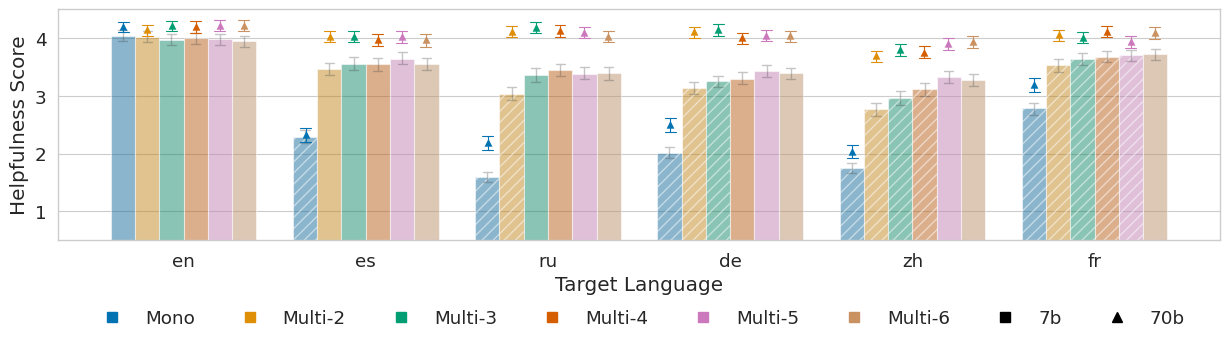

In [76]:
def plot_llm_judge_score_distribution_differences_v1(df1, df2, df1_id, df2_id, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets_1 = [l for l in ordered_alpaca_test_sets if l in df1['test_set'].unique()]
    test_sets_2 = [l for l in ordered_alpaca_test_sets if l in df2['test_set'].unique()]

    if test_sets_1 != test_sets_2:
        raise RuntimeError('test sets are not equal!')
        
    model_names_1 = [m for m in df1['model_name'].unique()]
    model_names_2 = [m for m in df2['model_name'].unique()]
    
    markers = ['s', '^']
    
    # baseline setting
    sns.barplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.3,
                # errorbar='sd', capsize=0.3,
                err_kws={"linewidth": 1.0, "alpha": 0.3},
                alpha=0.5,
                order=test_sets_1,
                hue_order=model_names_1,
                )
    
    # # set alpha of error bars to 0.5
    # for errorbar in ax.lines[1::2]:
    #     errorbar.set_alpha(0.5)

    # experimental setting
    sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.06,
                # errorbar='sd', capsize=0.3,
                err_kws={
                    "linewidth": 0.8, 
                    # "alpha": 0.6, 
                    # "color": "k"
                    },
                alpha=1.0,
                markers=markers[1], 
                markersize=3.0,
                order=test_sets_2,
                hue_order=model_names_2,
                dodge=0.66,
                linestyle='none',
                )

    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets_1):
        for j, model_name in enumerate(model_names_1):
            # The index of the bar in the patches list
            index = i * len(model_names_1) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch("///")
        else:
            bar.set_hatch('')
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # fix ylim to 1-6
    ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    legend = ax.get_legend()

    legend_colors = []
    for handle in legend.legend_handles:
        if isinstance(handle, mlines.Line2D):
            legend_colors.append(handle.get_color())
        else:
            pass

    legend_colors = legend_colors[:len(model_names_1)]
    print(legend_colors)
    
    # define proxy artists for legend
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

    handles = [f("s", i) for i in legend_colors]
    handles += [f(i, "k") for i in markers]

    # get labels from legend
    labels = [text.get_text() for text in legend.get_texts()][:len(model_names_1)] + [df1_id, df2_id]
    
    print(handles)
    print(labels)
    
    # increase legend marker size
    for handle in handles:
        handle.set_markersize(7.0)

    # add custom legend
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.45), ncols=8, frameon=False)

    # get custom legend using only df1
    # handles, labels = ax.get_legend_handles_labels()
    # print(handles)
    # print(labels)
    # handles = handles[:len(model_names_1)]
    # labels = labels[:len(model_names_1)]

    # # set the colors of the handles to have alpha=1
    # for handle in handles:
    #     handle.set_alpha(1.0)

    # # add custom legend
    # ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.45), ncols=8, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf1 = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6']))]
sdf1 = sdf1[sdf1['test_set'].isin(ordered_alpaca_test_sets)]
# sdf1 = sdf1[sdf1['test_set'].isin(['en', 'es', 'ru', 'de', 'zh', 'fr'])]
# sdf1 = sdf1[sdf1['test_set'].isin(['vi', 'bg', 'no', 'hi', 'el', 'is'])]
# sdf1 = sdf1[~sdf1['test_set'].isin(['is'])]

sdf1 = sdf1[ (sdf1['eval_src'] == 'source') & (sdf1['eval_tgt'] == 'system') ]
sdf1['model_name'] = sdf1['model_name'].str.replace('Llama-2', '').str.replace('MT', '').str.strip()
print(len(sdf1))
sdf2 = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6']))]
sdf2 = sdf2[sdf2['test_set'].isin(ordered_alpaca_test_sets)]
# sdf2 = sdf2[sdf2['test_set'].isin(['en', 'es', 'ru', 'de', 'zh', 'fr'])]
# sdf2 = sdf2[sdf2['test_set'].isin(['vi', 'bg', 'no', 'hi', 'el', 'is'])]
# sdf2 = sdf2[~sdf2['test_set'].isin(['is'])]

sdf2 = sdf2[ (sdf2['eval_src'] == 'source') & (sdf2['eval_tgt'] == 'system') ]
sdf2['model_name'] = sdf2['model_name'].str.replace('Llama-2 70B', '').str.replace('MT', '').str.strip()
print(len(sdf2))
print(sdf1.columns)
print(sdf2.columns)

plot_llm_judge_score_distribution_differences_v1(
    sdf1,
    sdf2, 
    df1_id='7b',
    df2_id='70b',
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_70b.png'
    )



91712
91663
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,', 'eval_OneLove'],
      dtype='object')
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,', 'eval_OneLove'],
      dtype='object')
[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451)]
[<matplotlib.lines.Line2D object at 0

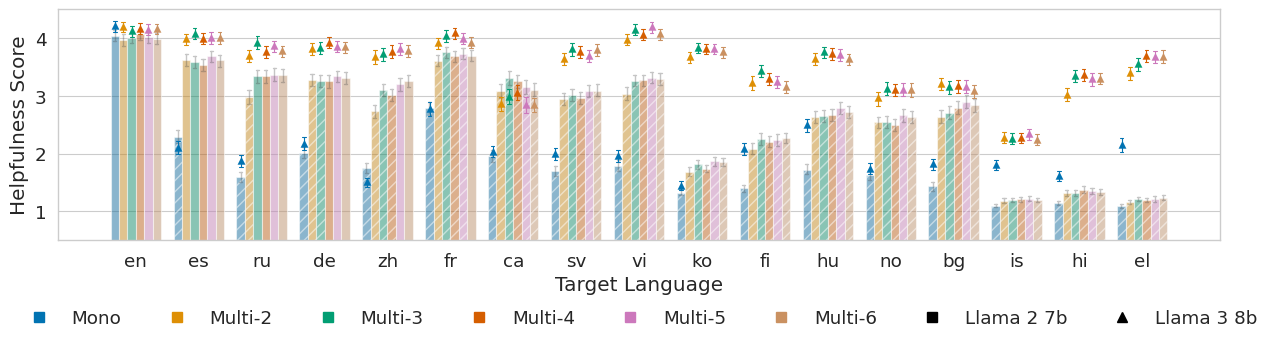

In [79]:
sdf1 = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6']))]
sdf1 = sdf1[sdf1['test_set'].isin(ordered_alpaca_test_sets)]
# sdf1 = sdf1[sdf1['test_set'].isin(['en', 'es', 'ru', 'de', 'zh', 'fr'])]
# sdf1 = sdf1[sdf1['test_set'].isin(['vi', 'bg', 'no', 'hi', 'el', 'is'])]
# sdf1 = sdf1[~sdf1['test_set'].isin(['is'])]

sdf1 = sdf1[ (sdf1['eval_src'] == 'source') & (sdf1['eval_tgt'] == 'system') ]
sdf1['model_name'] = sdf1['model_name'].str.replace('Llama-2', '').str.replace('MT', '').str.strip()
print(len(sdf1))
sdf2 = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-3 Mono', 'Llama-3 Multi-2', 'Llama-3 Multi-3', 'Llama-3 Multi-4', 'Llama-3 Multi-5', 'Llama-3 Multi-6']))]
sdf2 = sdf2[sdf2['test_set'].isin(ordered_alpaca_test_sets)]
# sdf2 = sdf2[sdf2['test_set'].isin(['en', 'es', 'ru', 'de', 'zh', 'fr'])]
# sdf2 = sdf2[sdf2['test_set'].isin(['vi', 'bg', 'no', 'hi', 'el', 'is'])]
# sdf2 = sdf2[~sdf2['test_set'].isin(['is'])]

sdf2 = sdf2[ (sdf2['eval_src'] == 'source') & (sdf2['eval_tgt'] == 'system') ]
sdf2['model_name'] = sdf2['model_name'].str.replace('Llama-3', '').str.replace('MT', '').str.strip()
print(len(sdf2))
print(sdf1.columns)
print(sdf2.columns)

plot_llm_judge_score_distribution_differences_v1(
    sdf1,
    sdf2, 
    df1_id='Llama 2 7b',
    df2_id='Llama 3 8b',
    # save_path='data/plots/chat_llm_judge_llama_incremental_diff_2vs3_2.png'
    )



76426
76423
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,', 'eval_OneLove'],
      dtype='object')
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,', 'eval_OneLove'],
      dtype='object')
['Multi-2', 'Multi-3', 'Multi-4', 'Multi-5', 'Multi-6']


/tmp/ipykernel_781591/2151573646.py:22: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 25 lines>
collections <Axes.ArtistList of 0 collections>


/tmp/ipykernel_781591/2151573646.py:46: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,


After plotting pp2
lines <Axes.ArtistList of 50 lines>
collections <Axes.ArtistList of 0 collections>
30 [(-0.33, 2.9877641824249164), (-0.264, 3.0345596432552955), (-0.165, 3.3363128491620113), (-0.099, 3.3670745272525027), (0.0, 3.344097995545657), (0.066, 3.447045707915273), (0.16499999999999998, 3.368186874304783), (0.23099999999999998, 3.3859844271412682), (0.33, 3.361915367483296), (0.396, 3.393095768374165), (0.6699999999999999, 3.2814238042269186), (0.736, 3.133630289532294), (0.835, 3.253615127919911), (0.901, 3.252222222222222), (1.0, 3.261401557285873), (1.066, 3.3), (1.165, 3.338888888888889), (1.231, 3.433333333333333), (1.33, 3.3092324805339266), (1.3960000000000001, 3.391111111111111), (1.67, 2.7416481069042318), (1.736, 2.769487750556793), (1.835, 3.097777777777778), (1.901, 2.9609375), (2.0, 3.0144927536231885), (2.066, 3.111111111111111), (2.165, 3.202447163515017), (2.231, 3.3303670745272527), (2.33, 3.2558398220244715), (2.396, 3.2703003337041157)]
['Multi-2', 'Mult

/tmp/ipykernel_781591/2151573646.py:22: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 25 lines>
collections <Axes.ArtistList of 0 collections>


/tmp/ipykernel_781591/2151573646.py:46: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,


After plotting pp2
lines <Axes.ArtistList of 50 lines>
collections <Axes.ArtistList of 0 collections>
30 [(-0.33, 3.6224944320712695), (-0.264, 3.467185761957731), (-0.165, 3.5877777777777777), (-0.099, 3.56), (0.0, 3.5322222222222224), (0.066, 3.542825361512792), (0.16499999999999998, 3.6855555555555557), (0.23099999999999998, 3.6384872080088986), (0.33, 3.612222222222222), (0.396, 3.548888888888889), (0.6699999999999999, 3.6073414905450503), (0.736, 3.53), (0.835, 3.7552836484983314), (0.901, 3.6366666666666667), (1.0, 3.6844444444444444), (1.066, 3.6766666666666667), (1.165, 3.732222222222222), (1.231, 3.7048997772828507), (1.33, 3.6911111111111112), (1.3960000000000001, 3.72), (1.67, 3.082222222222222), (1.736, 3.04), (1.835, 3.316666666666667), (1.901, 3.287777777777778), (2.0, 3.2558398220244715), (2.066, 3.255011135857461), (2.165, 3.151111111111111), (2.231, 3.1766666666666667), (2.33, 3.1055555555555556), (2.396, 3.1134593993325916)]
['Multi-2', 'Multi-3', 'Multi-4', 'Multi-5'

/tmp/ipykernel_781591/2151573646.py:22: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 25 lines>
collections <Axes.ArtistList of 0 collections>


/tmp/ipykernel_781591/2151573646.py:46: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,


After plotting pp2
lines <Axes.ArtistList of 50 lines>
collections <Axes.ArtistList of 0 collections>
30 [(-0.33, 2.9465478841870825), (-0.264, 2.9043381535038932), (-0.165, 3.0155728587319244), (-0.099, 3.067853170189099), (0.0, 2.959955506117909), (0.066, 3.056729699666296), (0.16499999999999998, 3.081111111111111), (0.23099999999999998, 3.1191536748329622), (0.33, 3.0902004454342986), (0.396, 3.123608017817372), (0.6699999999999999, 2.5450500556173528), (0.736, 2.5083426028921023), (0.835, 2.5517241379310347), (0.901, 2.582869855394883), (1.0, 2.4966666666666666), (1.066, 2.57174638487208), (1.165, 2.661111111111111), (1.231, 2.5951056729699666), (1.33, 2.6422222222222222), (1.3960000000000001, 2.618888888888889), (1.67, 2.6407119021134595), (1.736, 2.720800889877642), (1.835, 2.707777777777778), (1.901, 2.9777530589543937), (2.0, 2.796440489432703), (2.066, 2.8398220244716352), (2.165, 2.9010011123470525), (2.231, 3.01), (2.33, 2.8333333333333335), (2.396, 3.006674082313682)]
['Mul

/tmp/ipykernel_781591/2151573646.py:22: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 25 lines>
collections <Axes.ArtistList of 0 collections>


/tmp/ipykernel_781591/2151573646.py:46: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,


After plotting pp2
lines <Axes.ArtistList of 50 lines>
collections <Axes.ArtistList of 0 collections>
30 [(-0.33, 3.0355555555555553), (-0.264, 3.0722222222222224), (-0.165, 3.2622222222222224), (-0.099, 3.2547274749721913), (0.0, 3.2688888888888887), (0.066, 3.2622222222222224), (0.16499999999999998, 3.3133333333333335), (0.23099999999999998, 3.275055679287305), (0.33, 3.287777777777778), (0.396, 3.2844444444444445), (0.6699999999999999, 2.0855555555555556), (0.736, 2.198888888888889), (0.835, 2.2455555555555557), (0.901, 2.2933333333333334), (1.0, 2.207777777777778), (1.066, 2.2455555555555557), (1.165, 2.2369299221357064), (1.231, 2.267777777777778), (1.33, 2.266963292547275), (1.3960000000000001, 2.2688888888888887), (1.67, 2.6333333333333333), (1.736, 2.6077777777777778), (1.835, 2.6585094549499444), (1.901, 2.6763392857142856), (2.0, 2.6711259754738017), (2.066, 2.7861915367483294), (2.165, 2.789532293986637), (2.231, 2.7563959955506117), (2.33, 2.7230255839822024), (2.396, 2.831

/tmp/ipykernel_781591/2151573646.py:22: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 25 lines>
collections <Axes.ArtistList of 0 collections>


/tmp/ipykernel_781591/2151573646.py:46: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,


After plotting pp2
lines <Axes.ArtistList of 50 lines>
collections <Axes.ArtistList of 0 collections>
30 [(-0.33, 1.1866666666666668), (-0.264, 1.1711111111111112), (-0.165, 1.1933333333333334), (-0.099, 1.2366666666666666), (0.0, 1.2057842046718577), (0.066, 1.2122222222222223), (0.16499999999999998, 1.2202447163515018), (0.23099999999999998, 1.2291434927697442), (0.33, 1.1926503340757237), (0.396, 1.235817575083426), (0.6699999999999999, 1.3177777777777777), (0.736, 1.2366666666666666), (0.835, 1.318888888888889), (0.901, 1.311457174638487), (1.0, 1.3768115942028984), (1.066, 1.3070077864293659), (1.165, 1.3544444444444443), (1.231, 1.3815350389321468), (1.33, 1.3403781979977754), (1.3960000000000001, 1.31), (1.67, 1.1601779755283648), (1.736, 1.1655555555555555), (1.835, 1.2162764771460424), (1.901, 1.2177777777777778), (2.0, 1.1959910913140313), (2.066, 1.1854748603351954), (2.165, 1.2082405345211582), (2.231, 1.2333333333333334), (2.33, 1.2369299221357064), (2.396, 1.2313681868743

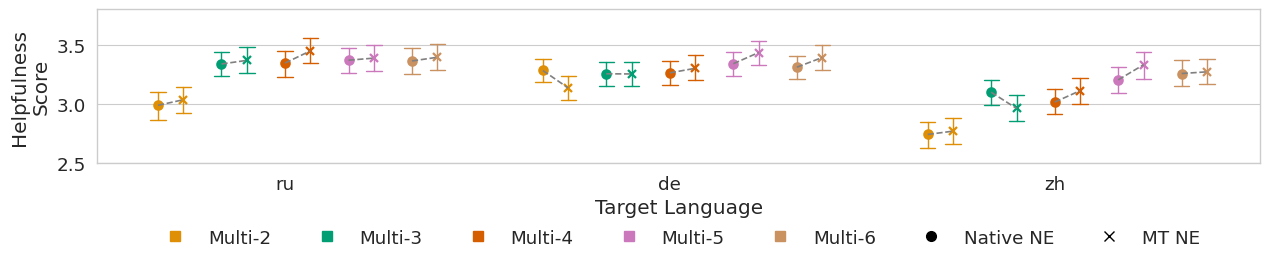

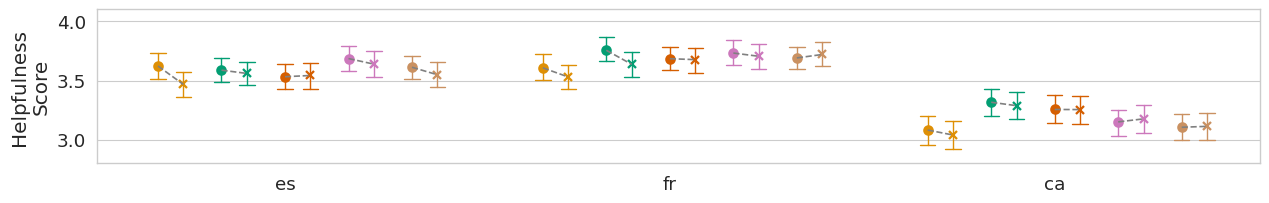

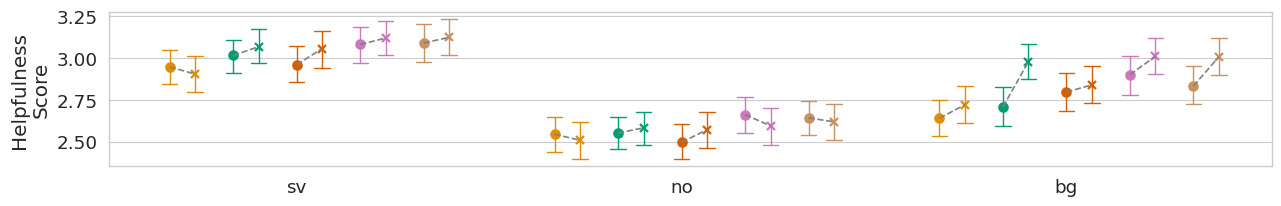

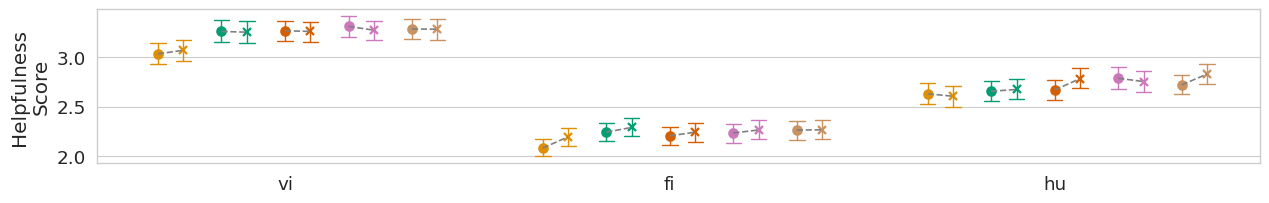

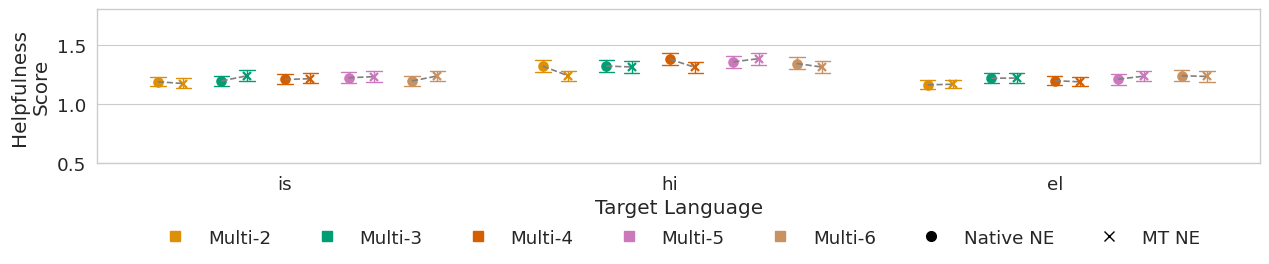

In [107]:
def plot_llm_judge_score_distribution_differences_v2(df1, df2, df1_id, df2_id, title=None, show_legend=True, set_ylims=True, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 2))
    
    test_sets_1 = [l for l in ordered_alpaca_test_sets if l in df1['test_set'].unique()]
    test_sets_2 = [l for l in ordered_alpaca_test_sets if l in df2['test_set'].unique()]

    if test_sets_1 != test_sets_2:
        raise RuntimeError('test sets are not equal!')
        
    model_names_1 = [m for m in df1['model_name'].unique()]
    model_names_2 = [m for m in df2['model_name'].unique()]
    
    print(model_names_1)
    
    dodge_value = 0.66 if len(model_names_1) > 1 else 0.0
    markers = ['o', 'x']

    offset = 0.066

    pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95),
                capsize=0.04,
                err_kws={
                    "linewidth": 1.0, 
                    # "color": "k"
                    }, 
                markersize=6.0,
                alpha=1.0,
                markers=markers[0],
                order=test_sets_1,
                hue_order=model_names_1,
                dodge=dodge_value,
                linestyle='none',
                palette=sns.color_palette()[1:],
                )
    
    # Record the number of lines and collections before plotting pp2
    num_lines_before = len(ax.lines)
    num_collections_before = len(ax.collections)
    print('Before plotting pp2')
    print('lines', ax.lines)
    print('collections', ax.collections)

    pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), 
                capsize=0.04, 
                err_kws={
                    "linewidth": 1.0, 
                    # "color": "k"
                    }, 
                markersize=6.0,
                alpha=1.0,
                markers=markers[1], 
                order=test_sets_2,
                hue_order=model_names_2,
                dodge=dodge_value,
                linestyle='none',
                palette=sns.color_palette()[1:],
                )
    
    print('After plotting pp2')
    print('lines', ax.lines)
    print('collections', ax.collections)

    # Shift only the lines and collections added by pp2
    for i, line in enumerate(ax.lines[num_lines_before:]):
        x_positions = line.get_xdata()
        # print(i, line, x_positions)
        x_positions = [x + offset for x in x_positions]
        # print(i, line, x_positions)
        line.set_xdata(x_positions)

    # Function to check if a line represents a single point
    def is_single_point_line(line):
        x_data, y_data = line.get_data()
        # only interested in lines with 3 points (lines with nan values indicate error bars)
        return len(x_data) == 3 and len(y_data) == 3

    # Extracting coordinates for single-point lines
    line_points = []
    for line in ax.lines:
        if is_single_point_line(line):
            x, y = line.get_data()
            for i in range(len(x)):
                line_points.append((x[i], y[i]))
    

    # sort line_points by x coordinate
    line_points = sorted(line_points, key=lambda x: x[0])
    print(len(line_points), line_points)

    # # draw lines from line_coordinates [0, 1], [2, 3], [4, 5], ...
    # colors = sns.color_palette()[1:]
    for i in range(0, len(line_points), 2):
        x1, y1 = line_points[i]
        x2, y2 = line_points[i + 1]
        # color = colors[i // 2 % len(colors)]
        # print(color)
        plt.plot([x1, x2], [y1, y2], linestyle='--', color='gray')

    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness\nScore')
    
    if set_ylims:
        if test_sets_1 == ['ru', 'de', 'zh']:
            ax.set_ylim(2.5, 3.8)
        elif test_sets_1 == ['es', 'fr', 'ca']:
            ax.set_ylim(2.8, 4.1)
        elif test_sets_1 == ['sv', 'bg', 'no']:
            ax.set_ylim(2.3, 3.5)
        elif test_sets_1 == ['is', 'hi', 'el']:
            ax.set_ylim(0.5, 1.8)
            
    ax.set_title(title)

    legend = ax.get_legend()    
    legend_colors = [handle.get_color() for handle in legend.legend_handles][:len(model_names_1)]

    # get labels from legend
    labels = [text.get_text() for text in legend.get_texts()][:len(model_names_1)]

    # define proxy artists for legend
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

    handles = [f("s", i) for i in legend_colors]
    handles += [f(i, "k") for i in markers]

    # get colors from df1 and shapes from df1 and df2
    labels = labels[:len(model_names_1)] + [df1_id, df2_id]

    # increase legend marker size
    for handle in handles:
        handle.set_markersize(7.0)

    # add custom legend
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.65), ncols=8, frameon=False)

    if not show_legend:
        # test_sets_1 == ['es', 'fr', 'ca'] or test_sets_1 == ['sv', 'bg', 'no']:
        # hide legened
        legend.remove()
        # hide x-axis label
        ax.set_xlabel('')

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf1 = df[ (df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6']))]
sdf1 = sdf1[sdf1['test_set'].isin(ordered_alpaca_test_sets)]
sdf1 = sdf1[ (sdf1['eval_src'] == 'source') & (sdf1['eval_tgt'] == 'system') ]
sdf1['model_name'] = sdf1['model_name'].str.replace('Llama-2 ', '').str.strip()
print(len(sdf1))
sdf2 = df[ (df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6']))]
sdf2 = sdf2[sdf2['test_set'].isin(ordered_alpaca_test_sets)]
sdf2 = sdf2[ (sdf2['eval_src'] == 'source') & (sdf2['eval_tgt'] == 'system') ]
sdf2['model_name'] = sdf2['model_name'].str.replace('Llama-2', '').str.strip()
print(len(sdf2))
print(sdf1.columns)
print(sdf2.columns)


plot_llm_judge_score_distribution_differences_v2(
    sdf1[sdf1['test_set'].isin(['ru', 'de', 'zh'])],
    sdf2[sdf2['test_set'].isin(['ru', 'de', 'zh'])],
    'Native NE',
    'MT NE',
    show_legend=True,
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt.png'
    )

plot_llm_judge_score_distribution_differences_v2(
    sdf1[sdf1['test_set'].isin(['es', 'fr', 'ca'])],
    sdf2[sdf2['test_set'].isin(['es', 'fr', 'ca'])],
    'Native NE',
    'MT NE',
    show_legend=False,
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt_additional_langs_1.png'
    )

plot_llm_judge_score_distribution_differences_v2(
    sdf1[sdf1['test_set'].isin(['sv', 'bg', 'no'])],
    sdf2[sdf2['test_set'].isin(['sv', 'bg', 'no'])],
    'Native NE',
    'MT NE',
    show_legend=False,
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt_additional_langs_2.png'
    )

plot_llm_judge_score_distribution_differences_v2(
    sdf1[sdf1['test_set'].isin(['vi', 'hu', 'fi'])],
    sdf2[sdf2['test_set'].isin(['vi', 'hu', 'fi'])],
    'Native NE',
    'MT NE',
    show_legend=False,
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt_additional_langs_3.png'
    )


plot_llm_judge_score_distribution_differences_v2(
    sdf1[sdf1['test_set'].isin(['is', 'hi', 'el'])],
    sdf2[sdf2['test_set'].isin(['is', 'hi', 'el'])],
    'Native NE',
    'MT NE',
    show_legend=True,
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt_additional_langs_4.png'
    )
  

15274
15275
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,', 'eval_OneLove'],
      dtype='object')
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,', 'eval_OneLove'],
      dtype='object')
['Multi-2']


/tmp/ipykernel_781591/2328018553.py:23: UserWarning: 
The palette list has fewer values (0) than needed (1) and will cycle, which may produce an uninterpretable plot.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 14 lines>
collections <Axes.ArtistList of 0 collections>
After plotting pp2
lines <Axes.ArtistList of 28 lines>
collections <Axes.ArtistList of 0 collections>
0 []


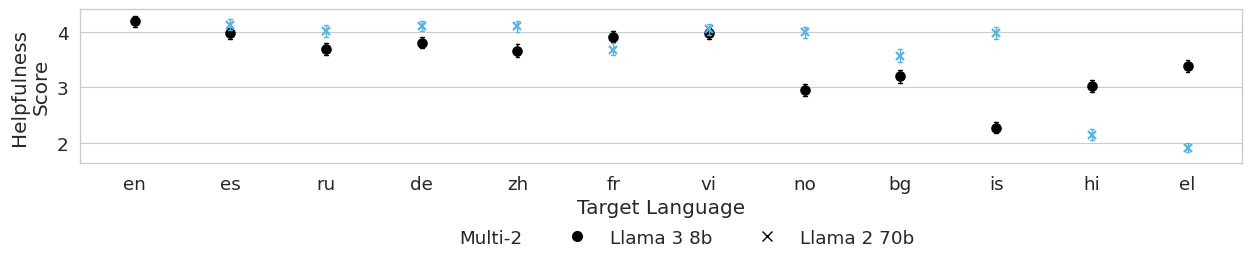

In [111]:

def plot_llm_judge_score_distribution_differences_v3(df1, df2, df1_id, df2_id, title=None, show_legend=True, set_ylims=True, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 2))
    
    test_sets_1 = [l for l in ordered_alpaca_test_sets if l in df1['test_set'].unique()]
    test_sets_2 = [l for l in ordered_alpaca_test_sets if l in df2['test_set'].unique()]

    if test_sets_1 != test_sets_2:
        raise RuntimeError('test sets are not equal!')
        
    model_names_1 = [m for m in df1['model_name'].unique()]
    model_names_2 = [m for m in df2['model_name'].unique()]
    
    print(model_names_1)
    
    dodge_value = 0
    markers = ['o', 'x']

    offset = 1.0

    pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95),
                capsize=0.04,
                err_kws={
                    "linewidth": 1.0, 
                    # "color": "k"
                    }, 
                markersize=6.0,
                alpha=1.0,
                markers=markers[0],
                order=test_sets_1,
                hue_order=model_names_1,
                dodge=dodge_value,
                linestyle='none',
                palette=sns.color_palette()[10:],
                )
    
    # Record the number of lines and collections before plotting pp2
    num_lines_before = len(ax.lines)
    num_collections_before = len(ax.collections)
    print('Before plotting pp2')
    print('lines', ax.lines)
    print('collections', ax.collections)

    pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), 
                capsize=0.04, 
                err_kws={
                    "linewidth": 1.0, 
                    # "color": "k"
                    }, 
                markersize=6.0,
                alpha=1.0,
                markers=markers[1], 
                order=test_sets_2,
                hue_order=model_names_2,
                dodge=dodge_value,
                linestyle='none',
                palette=sns.color_palette()[9:],
                )
    
    print('After plotting pp2')
    print('lines', ax.lines)
    print('collections', ax.collections)

    # Shift only the lines and collections added by pp2
    for i, line in enumerate(ax.lines[num_lines_before:]):
        x_positions = line.get_xdata()
        # print(i, line, x_positions)
        x_positions = [x + offset for x in x_positions]
        # print(i, line, x_positions)
        line.set_xdata(x_positions)

    # Function to check if a line represents a single point
    def is_single_point_line(line):
        x_data, y_data = line.get_data()
        # only interested in lines with 3 points (lines with nan values indicate error bars)
        return len(x_data) == 3 and len(y_data) == 3

    # Extracting coordinates for single-point lines
    line_points = []
    for line in ax.lines:
        if is_single_point_line(line):
            x, y = line.get_data()
            for i in range(len(x)):
                line_points.append((x[i], y[i]))
    

    # sort line_points by x coordinate
    line_points = sorted(line_points, key=lambda x: x[0])
    print(len(line_points), line_points)

    # # draw lines from line_coordinates [0, 1], [2, 3], [4, 5], ...
    # colors = sns.color_palette()[1:]
    for i in range(0, len(line_points), 2):
        x1, y1 = line_points[i]
        x2, y2 = line_points[i + 1]
        # color = colors[i // 2 % len(colors)]
        # print(color)
        plt.plot([x1, x2], [y1, y2], linestyle='--', color='gray')

    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness\nScore')
    
    if set_ylims:
        if test_sets_1 == ['ru', 'de', 'zh']:
            ax.set_ylim(2.5, 3.8)
        elif test_sets_1 == ['es', 'fr', 'ca']:
            ax.set_ylim(2.8, 4.1)
        elif test_sets_1 == ['sv', 'bg', 'no']:
            ax.set_ylim(2.3, 3.5)
        elif test_sets_1 == ['is', 'hi', 'el']:
            ax.set_ylim(0.5, 1.8)
            
    ax.set_title(title)

    legend = ax.get_legend()    
    legend_colors = [handle.get_color() for handle in legend.legend_handles][:len(model_names_1)]

    # get labels from legend
    labels = [text.get_text() for text in legend.get_texts()][:len(model_names_1)]

    # define proxy artists for legend
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

    handles = [f("s", i) for i in legend_colors]
    handles += [f(i, "k") for i in markers]

    # get colors from df1 and shapes from df1 and df2
    labels = labels[:len(model_names_1)] + [df1_id, df2_id]

    # increase legend marker size
    for handle in handles:
        handle.set_markersize(7.0)

    # add custom legend
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.65), ncols=8, frameon=False)

    if not show_legend:
        # test_sets_1 == ['es', 'fr', 'ca'] or test_sets_1 == ['sv', 'bg', 'no']:
        # hide legened
        legend.remove()
        # hide x-axis label
        ax.set_xlabel('')

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf1 = df[ (df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-3 Multi-2']))]
sdf1 = sdf1[sdf1['test_set'].isin(ordered_alpaca_test_sets)]
sdf1 = sdf1[ (sdf1['eval_src'] == 'source') & (sdf1['eval_tgt'] == 'system') ]
sdf1['model_name'] = sdf1['model_name'].str.replace('Llama-3 ', '').str.strip()
print(len(sdf1))
sdf2 = df[ (df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 70B MT Multi-2']))]
sdf2 = sdf2[sdf2['test_set'].isin(ordered_alpaca_test_sets)]
sdf2 = sdf2[ (sdf2['eval_src'] == 'source') & (sdf2['eval_tgt'] == 'system') ]
sdf2['model_name'] = sdf2['model_name'].str.replace('Llama-2', '').str.strip()
print(len(sdf2))
print(sdf1.columns)
print(sdf2.columns)

# sdf1 = sdf1[sdf1['test_set'].isin(['vi', 'bg', 'no', 'hi', 'el', 'is'])]
# plot_llm_judge_score_distribution_differences_v3(
#     sdf1[sdf1['test_set'].isin(['en', 'es', 'ru', 'de', 'zh', 'fr', 'vi', 'bg', 'no', 'hi', 'el', 'is'])],
#     sdf2[sdf2['test_set'].isin(['en', 'es', 'ru', 'de', 'zh', 'fr', 'vi', 'bg', 'no', 'hi', 'el', 'is'])],
#     'Llama 3 8b',
#     'Llama 2 70b',
#     show_legend=True,
#     set_ylims=False,
#     # save_path='data/plots/chat_llm_judge_llama_3_vs_llama_70b_incremental_diff.png'
#     )


bg    1800
no    1800
ca    1800
vi    1799
es    1799
hu    1799
fi    1799
el    1799
zh    1799
sv    1798
fr    1798
de    1798
is    1798
ko    1796
ru    1796
hi    1788
en     899
Name: test_set, dtype: int64


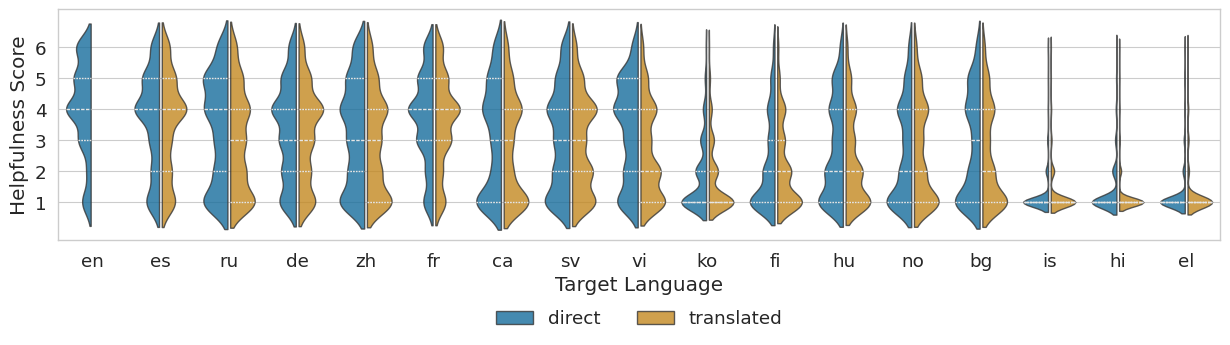

In [81]:

def plot_score_distribution_with_split_violins(df, title=None, save_path=None, hue='eval_type'):

    # for each test set, plot the distribution of eval_score for each model
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    
    fig, ax = plt.subplots(figsize=(15, 3))
    
    sns.violinplot(data=df, x='test_set', y='eval_score', hue=hue, ax=ax, 
                   fill=True, density_norm="count", common_norm=True,
                   split=True,
                   inner="quart",
                   dodge=True, gap=0.1,
                   alpha=0.8,
                   order=test_sets,
                #    inner_kws=dict(box_width=4, whis_width=1, color=".8"),
                   inner_kws=dict(color=".9"),
                   )
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # set y-ticks to integers 1-6
    ax.set_yticks(range(1, 7))

    ax.set_title(title)

    # place legend outside of plot at bottom with 3 columns
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=3, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf = df[ (df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Multi-6'])) ]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf = sdf[~sdf['test_set'].isin(['es', 'ru', 'de', 'zh', 'fr'])]
# sdf = sdf[~sdf['test_set'].isin(['en', 'ca', 'sv', 'bg', 'no', 'hi', 'el'])]
# sdf = sdf[~sdf['test_set'].isin(['is'])]

sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

plot_score_distribution_with_split_violins(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama_7b_translated_vs_direct_eval.png'
    )

# for seed in [0, 42, 723]:
#     sdf = df[ (df['model_name'].isin(['Llama-2 Multi-6'])) & (df['seed'] == seed) ] 
#     sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]

#     sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

#     plot_score_distribution_with_split_violins(
#         sdf, 
#         title='Distribution of LLM Judge Evaluation Scores: Direct vs. Translated Evaluation',
#         # save_path=f'data/plots/chat_llm_judge_llama_7b_s{seed}_translated_vs_direct_eval.png'
#         )

In [31]:
df['eval_model'].value_counts()

gpt-3.5-turbo-1106      592885
prometheus-7b-v2.0      122400
prometheus-8x7b-v2.0     29700
gpt-4-1106-preview        1497
Name: eval_model, dtype: int64

vi    1800
ko    1800
hi    1800
is    1800
bg    1800
no    1800
hu    1800
fi    1800
el    1800
es    1800
sv    1800
ca    1800
fr    1800
zh    1800
de    1800
ru    1800
en     900
Name: test_set, dtype: int64


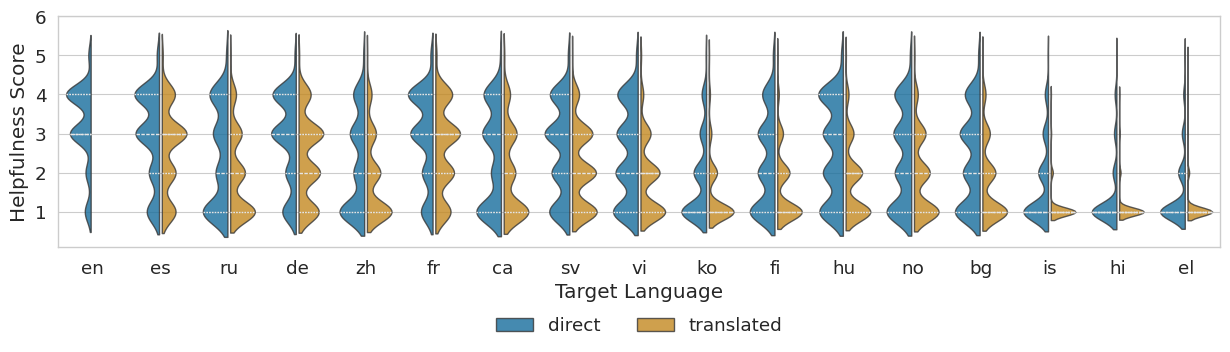

In [32]:
# compare direct vs. translated eval scores for prometheus
sdf = df[ (df['eval_model'] == 'prometheus-7b-v2.0') & (df['model_name'].isin(['Llama-2 Multi-2'])) ]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf = sdf[~sdf['test_set'].isin(['es', 'ru', 'de', 'zh', 'fr'])]
# sdf = sdf[~sdf['test_set'].isin(['en', 'ca', 'sv', 'bg', 'no', 'hi', 'el'])]
# sdf = sdf[~sdf['test_set'].isin(['is'])]

sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

plot_score_distribution_with_split_violins(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama_7b_translated_vs_direct_eval.png'
    )


vi    1800
ko    1800
hi    1800
is    1800
bg    1800
no    1800
hu    1800
fi    1800
el    1800
es    1800
sv    1800
ca    1800
fr    1800
zh    1800
de    1800
ru    1800
en     900
Name: test_set, dtype: int64


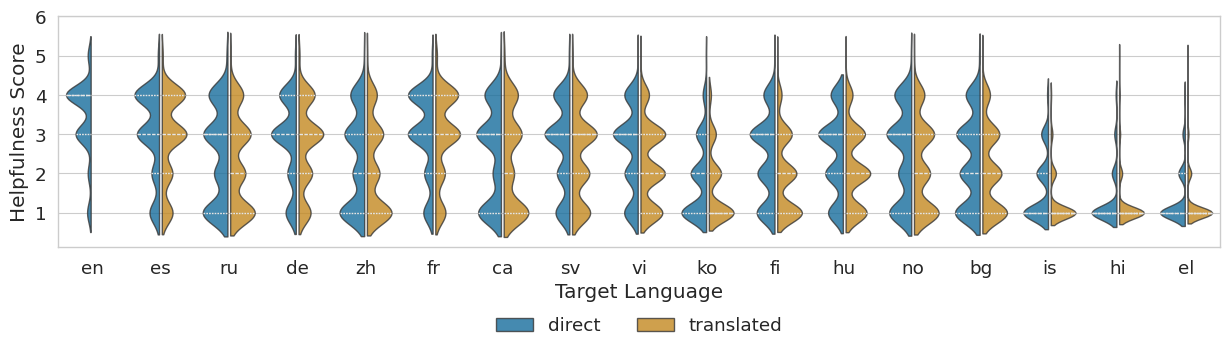

In [33]:
# compare direct vs. translated eval scores for prometheus
sdf = df[ (df['eval_model'] == 'prometheus-8x7b-v2.0') & (df['model_name'].isin(['Llama-2 Multi-2'])) ]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf = sdf[~sdf['test_set'].isin(['es', 'ru', 'de', 'zh', 'fr'])]
# sdf = sdf[~sdf['test_set'].isin(['en', 'ca', 'sv', 'bg', 'no', 'hi', 'el'])]
# sdf = sdf[~sdf['test_set'].isin(['is'])]

sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

plot_score_distribution_with_split_violins(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama_7b_translated_vs_direct_eval.png'
    )


fr    900
ru    899
de    899
zh    899
en    898
fi    600
bg    600
no    600
hu    600
vi    600
es    600
ca    600
el    600
ko    599
sv    599
is    599
hi    599
Name: test_set, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11691 entries, 197026 to 241688
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_name      11691 non-null  object 
 1   test_set        11691 non-null  object 
 2   seed            11691 non-null  int64  
 3   eval_src        11691 non-null  object 
 4   eval_tgt        11691 non-null  object 
 5   finish_reason   11691 non-null  object 
 6   secs            11691 non-null  float64
 7   id              11691 non-null  int64  
 8   eval_reasoning  11691 non-null  object 
 9   eval_score      11691 non-null  float64
 10  source_lang     11691 non-null  object 
 11  system_lang     11691 non-null  object 
 12  context         11691 non-null  object 
 13  n_eval

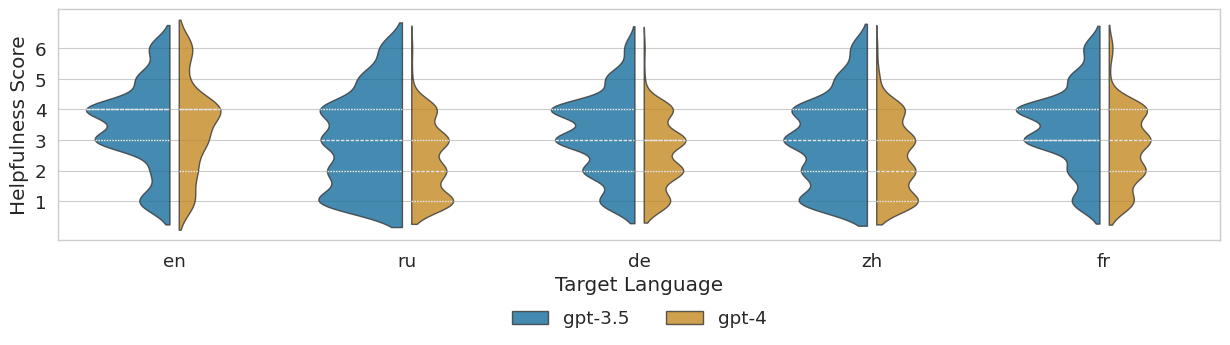

In [34]:
# comparing gpt-3.5 and gpt-4 as judges

sdf = df[ (df['model_name'].isin(['Llama-2 Multi-6'])) ]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[sdf['seed'] == 0]
print(sdf['test_set'].value_counts())
print(sdf.info())

# sdf = sdf[~sdf['test_set'].isin(['en', 'ca', 'sv', 'bg', 'no', 'hi', 'el'])]
# sdf = sdf[~sdf['test_set'].isin(['is'])]

sdf['eval_type'] = sdf.apply(lambda x: "gpt-4" if x['eval_model'].startswith('gpt-4') else "gpt-3.5", axis=1)
# drop test sets that are not available for both gpt-3.5 and gpt-4
gpt4_test_sets = list(sdf[sdf['eval_type'] == 'gpt-4']['test_set'].unique())
gpt35_test_sets = list(sdf[sdf['eval_type'] == 'gpt-3.5']['test_set'].unique())
print(gpt4_test_sets)
print(gpt35_test_sets)
sdf = sdf[sdf['test_set'].isin(gpt4_test_sets) & sdf['test_set'].isin(gpt35_test_sets)]

print(sdf['eval_type'].value_counts())

plot_score_distribution_with_split_violins(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama_7b_gpt35_vs_gpt4_eval.png'
    )


# LM Eval Harness

In [35]:
def load_lm_eval_results_file(file):
    with open(file, "r", encoding='utf8') as f:
        df = pd.DataFrame.from_dict(json.load(f)['results'])
        df['model_name'] = Path(file).stem
        return df

def get_lm_eval_results(results_dir):
    dfs = []
    for results_file in Path(results_dir).glob('*.json'):
        print(results_file)
        df = load_lm_eval_results_file(results_file)
        dfs.append(df)
    df = pd.concat(dfs, axis=0, ignore_index=False).reset_index()
    df = df.rename(columns={'index': 'metric'})

    # Reshape the dataframe, moving model_name and index to the index
    df_long = pd.melt(df, id_vars=['model_name', 'metric'], var_name='task_lang', value_name='score')

    # Split the task_lang into two separate columns for 'task' and 'lang'
    df_long[['task', 'lang']] = df_long['task_lang'].str.split('_', expand=True)

    # Drop the original task_lang column as it's no longer needed
    df_long.drop('task_lang', axis=1, inplace=True)

    # Now pivot to get the 'task', 'lang' and 'index' as part of the column MultiIndex
    df = df_long.pivot_table(index='model_name', columns=['task', 'lang', 'metric'], values='score')

    # # move model_name to front
    # cols = df.columns.tolist()
    # cols.insert(0, cols.pop(cols.index('model_name')))
    # df = df.reindex(columns=cols)
    
    # # split task and lang tags into multiple levels

    # df.set_index(['model_name', 'metric'], inplace=True)
    # df = df.unstack(level='metric')
    
    df.info()

    return df

df = get_lm_eval_results('data/lm_eval_harness')
df

###################

def process_single_dataset_df(df):

    # multiply all numeric values by 100
    df[df.select_dtypes(include=['number']).columns] *= 100
    # round all numeric values to 2 decimal places
    df = df.round(2)

    # get the list of langs in dataframe from the multi-index
    langs = df.columns.get_level_values(0).unique().tolist()
    
    for lang in langs:
        acc_col = (lang, 'acc')
        stderr_col = (lang, 'acc_stderr') 
        df[lang] = df[acc_col].astype(str) + ' ± ' + df[stderr_col].astype(str)

    # drop all acc_stderr columns from multi-index
    df.drop(df.filter(like='acc_stderr').columns, axis=1, inplace=True)

    # drop 'metric' level from multi-index
    df.columns = df.columns.droplevel(level=1)

    # drop model_name as index
    df.reset_index(inplace=True)

    df.replace({'model_name': name_map}, inplace=True)

    print(df['model_name'].unique())

    # # sort rows by model_name in name_map
    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df = df.sort_values(by=['model_name'])
    # # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    
    # subscript the stderror values in each cell
    # df = df.style.format(lambda x: x.replace('±', '\pm '))

    return df
print('\nPAWS-X\n')
print(process_single_dataset_df(df['pawsx']).to_latex(index=False))
print('\nXNLI\n')
print(process_single_dataset_df(df['xnli']).to_latex(index=False))
print('\nX-Winograd\n')
print(process_single_dataset_df(df['xwinograd']).to_latex(index=False))



data/lm_eval_harness/llama_2_70b_hf_guanaco_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml1_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml2_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml3_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml4_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml5_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml6_merged.json
data/lm_eval_harness/llama_2_7b_hf_guanaco_merged.json
data/lm_eval_harness/falcon_7b_guanaco_merged.json
data/lm_eval_harness/falcon_7b_ml1_merged.json
data/lm_eval_harness/falcon_7b_ml2_merged.json
data/lm_eval_harness/falcon_7b_ml3_merged.json
data/lm_eval_harness/falcon_7b_ml4_merged.json
data/lm_eval_harness/falcon_7b_ml5_merged.json
data/lm_eval_harness/llama_2_7b_hf_ml1_merged.json
data/lm_eval_harness/llama_2_7b_hf_ml2_merged.json
data/lm_eval_harness/llama_2_7b_hf_ml3_merged.json
data/lm_eval_harness/llama_2_7b_hf_ml4_merged.json
data/lm_eval_harness/llama_2_7b_hf_ml5_merged.json
data/lm_eval_harne

/tmp/ipykernel_781591/2368837047.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.select_dtypes(include=['number']).columns] *= 100
/tmp/ipykernel_781591/2368837047.py:86: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(process_single_dataset_df(df['pawsx']).to_latex(index=False))
/tmp/ipykernel_781591/2368837047.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_set    80 non-null     object 
 1   model_name  80 non-null     object 
 2   acc         80 non-null     float64
 3   stderr      80 non-null     float64
 4   lower_ci    80 non-null     float64
 5   upper_ci    80 non-null     float64
dtypes: float64(4), object(2)
memory usage: 3.9+ KB
['en', 'es', 'ru', 'de', 'zh', 'fr', 'vi', 'bg', 'hi', 'el']
['Mono', 'Multi-2', 'Multi-3', 'Multi-4', 'Multi-5', 'Multi-6', 'Multi-Guanaco', 'Base']
0 0 en Mono 0
0 1 en Multi-2 1
0 2 en Multi-3 2
0 3 en Multi-4 3
0 4 en Multi-5 4
0 5 en Multi-6 5
0 6 en Multi-Guanaco 6
0 7 en Base 7
1 0 es Mono 8
1 1 es Multi-2 9
1 2 es Multi-3 10
1 3 es Multi-4 11
1 4 es Multi-5 12
1 5 es Multi-6 13
1 6 es Multi-Guanaco 14
1 7 es Base 15
2 0 ru Mono 16
2 1 ru Multi-2 17
2 2 ru Multi-3 18
2 3 ru Multi-4 19
2 4 ru Multi-5 20
2 5

KeyError: 'Base'

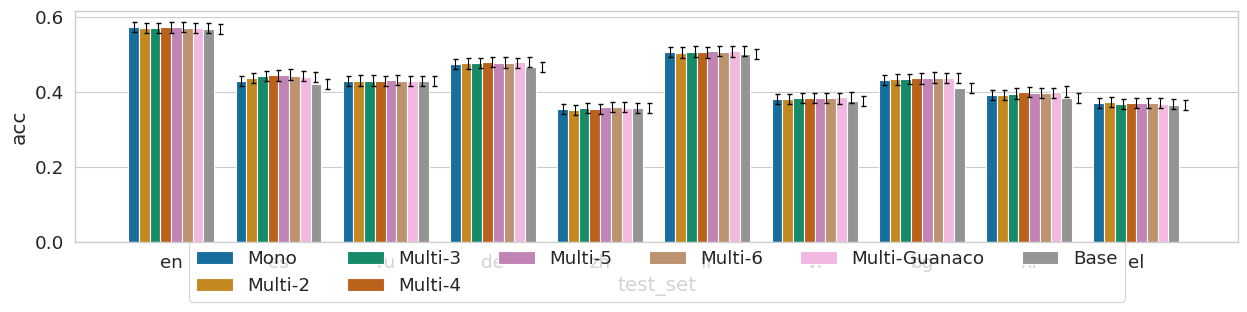

In [40]:
def plot_single_dataset_df(df, title=None, save_path=None, presentation_models=None, presentation_test_sets=None, use_resource_map=False):

    # df['ci_size'] = df['upper_ci'] - df['lower_ci']
    yerr = [df['acc'] - df['lower_ci'], df['upper_ci'] - df['acc']]

    # get the list of langs in dataframe from the multi-index
    test_sets = df['test_set'].unique().tolist()
    model_names = df['model_name'].unique().tolist()
    
    print(test_sets)
    print(model_names)
    
    # # Get the positions of the bars in the barplot
    # x_values = []
    # for test in test_sets:
    #     for i, model in enumerate(model_names):
    #         x_values.append(test_sets.index(test) + i * 0.2 - 0.1)

    fig, ax = plt.subplots(figsize=(15, 3))

    ax = sns.barplot(data=df,
                x='test_set', 
                y='acc', 
                hue='model_name', 
                # errorbar=("ci", 95), capsize=0.3,
                # err_kws={"linewidth": 1.0},
                alpha=1.0,
                # hue_order=ordered_test_sets,
                ax=ax
                )

    # Iterate over each unique test_set and model_name to place the error bars
    for test_set in df['test_set'].unique():
        for model_name in df['model_name'].unique():
            subset = df[(df['test_set'] == test_set) & (df['model_name'] == model_name)]
            if not subset.empty:
                row = subset.iloc[0]
                x = ax.get_xticks()[list(df['test_set'].unique()).index(test_set)]
                hue_offset = 0.115 * list(df['model_name'].unique()).index(model_name) - 0.35
                plt.errorbar(x=x + hue_offset, y=row['acc'], 
                             yerr=[[row['acc'] - row['lower_ci']], [row['upper_ci'] - row['acc']]], 
                             fmt='none', c='black', 
                             linewidth=0.8,
                             capsize=1.8
                             )

    # put legend outside of plot at bottom
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=6)


   # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]
    errorbars = ax.lines

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    sorted_errorbars = sorted(errorbars, key=lambda bar: bar.get_xdata()[0], reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
            # The index of the bar in the patches list
            index = i * len(model_names) + j
            print(i, j, test_set, model_name, index)
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info["test_set"] not in training_langs[info["model_name"].split()[-1]] and info["model_name"] != "base":
            bar.set_hatch("///")
        else:
            bar.set_hatch("")

        if presentation_models:
            if info['model_name'] not in model_names[:presentation_models]:
                bar.set_alpha(0.0)
                sorted_errorbars[i].set_alpha(0.0)
        
        if presentation_test_sets:
            if info['test_set'] not in test_sets[:presentation_test_sets]:
                bar.set_alpha(0.0)
                sorted_errorbars[i].set_alpha(0.0)
        
    # rename x-axis labels to resource_map
    if use_resource_map:
        ax.set_xticks([i for i in range(len(test_sets))])
        ax.set_xticklabels([resource_map[l] for l in test_sets])
        # pad the x-axis label 
        ax.set_xlabel('Target Language', labelpad=12)
        y_offset = -0.65
    else:
        ax.set_xlabel('Target Language')
        y_offset = -0.45

    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')
    
    # fix ylim to 1-6
    # ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    # legend at bottom
    ncols = len(model_names)

    # add custom legend
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')


    return

def calculate_95_confidence_intervals(data):
    """
    Adds 95% confidence intervals to the dataset.

    Args:
    data (pd.DataFrame): A DataFrame containing the columns 'acc', 'acc_stderr'.
    
    Returns:
    pd.DataFrame: Original DataFrame with two new columns 'lower_ci' and 'upper_ci'.
    """
    z_score = 1.96  # Z-score for 95% confidence

    # Calculating the confidence intervals
    data['lower_ci'] = data['acc'] - z_score * data['stderr']
    data['upper_ci'] = data['acc'] + z_score * data['stderr']

    return data

def format_dataframe_to_plot(df, dataset_name):

    # print(plot_single_dataset_df(df['pawsx'].unstack(level=0).reset_index()))
    df = df[dataset_name].unstack(level=0).reset_index().rename(columns={0: 'value'})
    # rename model_name using name_map
    df.replace({'model_name': name_map}, inplace=True)

    acc_df = df[df['metric'] == 'acc']
    stderr_df = df[df['metric'] == 'acc_stderr']

    # Merge the dataframes on language and model name
    df = pd.merge(acc_df, stderr_df, on=['lang', 'model_name'])
    df.rename(columns={'value_x': 'acc', 'value_y': 'stderr', 'lang': 'test_set'}, inplace=True)
    df.drop(['metric_x', 'metric_y'], axis=1, inplace=True)

    # rename el to el*
    df['test_set'] = df['test_set'].str.replace('el', 'el')
    df['test_set'] = df['test_set'].str.replace('hi', 'hi')
    

    return calculate_95_confidence_intervals(df)

sdf = format_dataframe_to_plot(df, 'xnli')
sdf = sdf[sdf['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 
                                  'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 
                                  'Llama-2 Multi-Guanaco', 'Llama-2 Base'])]
sdf = apply_sort(sdf, ordered_test_sets=ordered_alpaca_test_sets)

# drop test sets for presentation plots
# sdf = sdf[sdf['test_set'].isin(['en', 'zh', 'de', 'bg', 'hi'])]

sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.strip()
# sdf[sdf['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2'])].to_csv('scratch/xnli_sample.csv')
sdf

plot_single_dataset_df(
    sdf, 
    save_path='data/plots/xnli_llama2_7b_incremental.png'
    )


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_set    70 non-null     object 
 1   model_name  70 non-null     object 
 2   acc         70 non-null     float64
 3   stderr      70 non-null     float64
 4   lower_ci    70 non-null     float64
 5   upper_ci    70 non-null     float64
dtypes: float64(4), object(2)
memory usage: 3.4+ KB
['en', 'es', 'ru', 'de', 'zh', 'fr', 'vi', 'bg', 'hi', 'el']
['Mono', 'Multi-2', 'Multi-3', 'Multi-4', 'Multi-5', 'Multi-6', 'Multi-Guanaco']
0 0 en Mono 0
0 1 en Multi-2 1
0 2 en Multi-3 2
0 3 en Multi-4 3
0 4 en Multi-5 4
0 5 en Multi-6 5
0 6 en Multi-Guanaco 6
1 0 es Mono 7
1 1 es Multi-2 8
1 2 es Multi-3 9
1 3 es Multi-4 10
1 4 es Multi-5 11
1 5 es Multi-6 12
1 6 es Multi-Guanaco 13
2 0 ru Mono 14
2 1 ru Multi-2 15
2 2 ru Multi-3 16
2 3 ru Multi-4 17
2 4 ru Multi-5 18
2 5 ru Multi-6 19
2 6 ru Multi-Guanaco 20

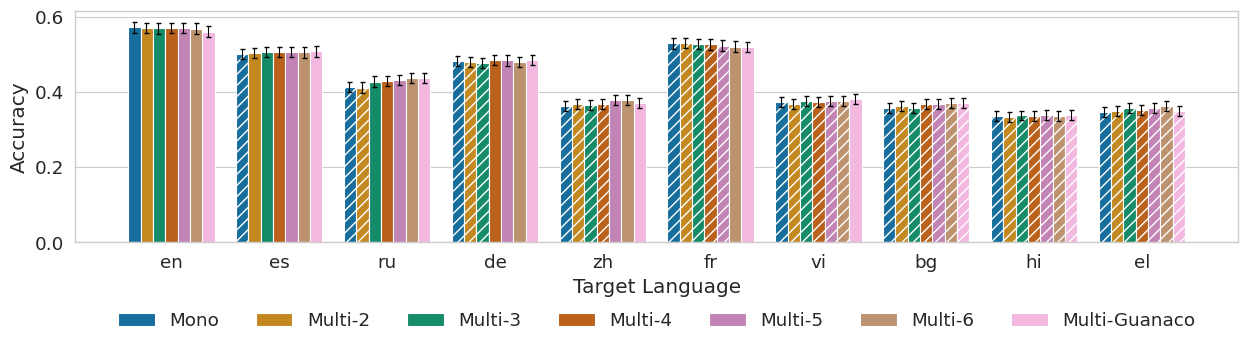

In [37]:
sdf = format_dataframe_to_plot(df, 'xnli')
sdf = sdf[sdf['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6', 'Falcon Multi-Guanaco'])]
sdf = apply_sort(sdf, ordered_test_sets=ordered_alpaca_test_sets)
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.replace('/ca', '').str.strip()

plot_single_dataset_df(
    sdf, 
    save_path='data/plots/xnli_falcon_7b_incremental.png'
    )



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_set    70 non-null     object 
 1   model_name  70 non-null     object 
 2   acc         63 non-null     float64
 3   stderr      63 non-null     float64
 4   lower_ci    63 non-null     float64
 5   upper_ci    63 non-null     float64
dtypes: float64(4), object(2)
memory usage: 3.4+ KB
['en', 'es', 'ru', 'de', 'zh', 'fr', 'vi', 'bg', 'hi', 'el']
['Mono', 'Multi-2', 'Multi-3', 'Multi-4', 'Multi-5', 'Multi-6', 'Multi-Guanaco']
0 0 en Mono 0
0 1 en Multi-2 1
0 2 en Multi-3 2
0 3 en Multi-4 3
0 4 en Multi-5 4
0 5 en Multi-6 5
0 6 en Multi-Guanaco 6
1 0 es Mono 7
1 1 es Multi-2 8
1 2 es Multi-3 9
1 3 es Multi-4 10
1 4 es Multi-5 11
1 5 es Multi-6 12
1 6 es Multi-Guanaco 13
2 0 ru Mono 14
2 1 ru Multi-2 15
2 2 ru Multi-3 16
2 3 ru Multi-4 17
2 4 ru Multi-5 18
2 5 ru Multi-6 19
2 6 ru Multi-Guanaco 20

IndexError: list index out of range

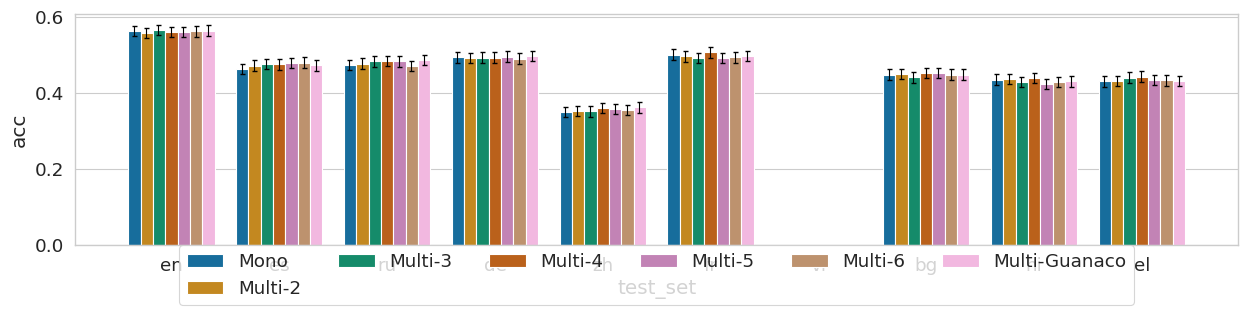

In [38]:
sdf = format_dataframe_to_plot(df, 'xnli')
sdf = sdf[sdf['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6', 'Llama-2 70B Multi-Guanaco'])]
sdf = apply_sort(sdf, ordered_test_sets=ordered_alpaca_test_sets)
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.replace('MT', '').str.replace('/ca', '').str.replace('70B', '').str.strip()

plot_single_dataset_df(
    sdf, 
    save_path='data/plots/xnli_llama_70b_incremental.png'
    )


# XCSQA results

In [21]:
# XCSQA

def get_xcsqa_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for output_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        df = pd.read_json(output_file, lines=True)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(output_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set

        if prompt == 'blank':
            dataset, split, prompt_lang, tgt_lang = test_set.split('_')
            if prompt_lang == 'en':
                prompt = 'en'
            else:
                prompt = 'X'
                
        df['prompt'] = prompt
        df['seed'] = seed

        dfs.append(df)
            
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('prompt')))
    
    df = df.reindex(columns=cols)

    return df

df = get_xcsqa_results('data/xcsqa_outputs/')

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

df = apply_sort(df, ordered_test_sets=ordered_xcsr_test_sets)

# compute scores for each item
df['score'] = df.apply(lambda x: 1 if x['system'][0].lower() == x['reference'][0].lower() else 0, axis=1)

# def score_response(row):
#     tgt = row['reference'][0].lower()

#     if row['system'][0].lower() == tgt:
#         return 1
    
#     else:
#         answer = re.search(r'\b([ABCDE])([\b\'"])?', row['system'])
#         if answer:
#             if answer.group(0).strip().lower() == tgt:
#                 return 1
    
#     return 0

df['score'] = df.apply(score_response, axis=1)

print(df['score'].value_counts())
print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   model_name     750000 non-null  object 
 1   test_set       750000 non-null  object 
 2   seed           750000 non-null  int64  
 3   prompt         750000 non-null  object 
 4   system         750000 non-null  object 
 5   finish_reason  750000 non-null  object 
 6   source         750000 non-null  object 
 7   secs           750000 non-null  float64
 8   reference      750000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 51.5+ MB
0    566436
1    183564
Name: score, dtype: int64
en:en    57000
en:es    57000
en:ru    57000
en:de    57000
en:fr    57000
es:es    57000
ru:ru    57000
de:de    57000
en:zh    42000
en:vi    42000
en:hi    42000
zh:zh    42000
fr:fr    42000
vi:vi    42000
hi:hi    42000
Name: test_set, dtype: int64
Llama-2 Mono             450

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,reference,score
0,Llama-2 Mono,en:en,0,en,"E""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nThe dental office handled a lot of patients who experienced traumatic mouth injury, where were these patients coming from?\n\nOptions:\n\nA: town\nB: michigan\nC: hospital\nD: schools\nE: office building\n\n### Assistant: """,0.031984,"[C, hospital]",0
1,Llama-2 Mono,en:en,0,en,"E""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nWhere can you find bald eagles and cheese in the midwest?\n\nOptions:\n\nA: colorado\nB: currency\nC: iowa\nD: arctic\nE: wisconsin\n\n### Assistant: """,0.031984,"[E, wisconsin]",1
2,Llama-2 Mono,en:en,0,en,"E: enjoy working""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nWhy would a person stay at their job without being paid?\n\nOptions:\n\nA: thank god\nB: wait in line\nC: volunteer\nD: offer help\nE: enjoy working\n\n### Assistant: """,0.031984,"[E, enjoy working]",1
3,Llama-2 Mono,en:en,0,en,"E""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nThe electric fan had gotten too loud and was bothering others, though they allowed many personal things on desks he was required to turn it off where?\n\nOptions:\n\nA: closet\nB: office\nC: hot room\nD: home\nE: hallway\n\n### Assistant: """,0.031984,"[B, office]",0
4,Llama-2 Mono,en:en,0,en,"A""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nIf air is held down by gravity, what does it usually cover.\n\nOptions:\n\nA: sky\nB: space shuttle\nC: cupboard\nD: surface of earth\nE: house\n\n### Assistant: """,0.031984,"[D, surface of earth]",0


In [22]:
type(df.iloc[0]['reference'])

list

In [23]:
df[ (df['test_set'] == 'ru:ru') & (df['score'] != 1) ]

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,reference,score
27000,Llama-2 Mono,ru:ru,0,X,"D""",stop,"### Human: Тебе будет предложен вопрос, имеющий несколько возможных ответов. Выбери наиболее подходящий вариант ответа из ""A"", ""B"", ""C"", ""D"" или ""E"" основываясь на своих знаниях. Пожалуйста, дай ответ одной буквой в кавычках.\n\nВопрос:\n\nДжо хотел знать правду, потому что он был академиком и южанином, чтобы узнать как можно больше. Он сделает что угодно в погоне за чем?\n\nВарианты:\n\nA: работать в выгоду\nB: дополнительные знания\nC: иметь значение\nD: свобода мыслей\nE: нахождение пути\n\n### Assistant: """,0.042370,"[B, дополнительные знания]",0
27001,Llama-2 Mono,ru:ru,0,X,"A""",stop,"### Human: Тебе будет предложен вопрос, имеющий несколько возможных ответов. Выбери наиболее подходящий вариант ответа из ""A"", ""B"", ""C"", ""D"" или ""E"" основываясь на своих знаниях. Пожалуйста, дай ответ одной буквой в кавычках.\n\nВопрос:\n\nКак студенты могут быть социальными при выполнении заданий?\n\nВарианты:\n\nA: армрестлинг\nB: учиться вместе\nC: философия обучения\nD: дальнейшее образование\nE: прочитанные книги\n\n### Assistant: """,0.042370,"[B, учиться вместе]",0
27004,Llama-2 Mono,ru:ru,0,X,"A""",stop,"### Human: Тебе будет предложен вопрос, имеющий несколько возможных ответов. Выбери наиболее подходящий вариант ответа из ""A"", ""B"", ""C"", ""D"" или ""E"" основываясь на своих знаниях. Пожалуйста, дай ответ одной буквой в кавычках.\n\nВопрос:\n\nКак называется ti, когда люди на работе собираются вместе для обмена информацией?\n\nВарианты:\n\nA: онлайн\nB: интернет\nC: перерыв на\nD: собрание\nE: справочник\n\n### Assistant: """,0.042370,"[D, собрание]",0
27006,Llama-2 Mono,ru:ru,0,X,"A""",stop,"### Human: Тебе будет предложен вопрос, имеющий несколько возможных ответов. Выбери наиболее подходящий вариант ответа из ""A"", ""B"", ""C"", ""D"" или ""E"" основываясь на своих знаниях. Пожалуйста, дай ответ одной буквой в кавычках.\n\nВопрос:\n\nЧто учитель должен делать для своих учеников?\n\nВарианты:\n\nA: углубление знаний\nB: групповые студенты\nC: приготовить обед\nD: испытание временем\nE: излагать факты\n\n### Assistant: """,0.042370,"[E, излагать факты]",0
27007,Llama-2 Mono,ru:ru,0,X,"A""",stop,"### Human: Тебе будет предложен вопрос, имеющий несколько возможных ответов. Выбери наиболее подходящий вариант ответа из ""A"", ""B"", ""C"", ""D"" или ""E"" основываясь на своих знаниях. Пожалуйста, дай ответ одной буквой в кавычках.\n\nВопрос:\n\nБритва с двойной кромкой использовалась для резки ленты. Он был найден в какой коробке?\n\nВарианты:\n\nA: аптека\nB: аптечка\nC: аптечка первой помощи\nD: бритвенный набор\nE: душ\n\n### Assistant: """,0.042370,"[C, аптечка первой помощи]",0
...,...,...,...,...,...,...,...,...,...,...
734994,Falcon Multi-Guanaco,ru:ru,723,X,"A"" отличается от ""B"" и ""C"" в что ""A"" не совпадает с ""B"" и ""C"", а ""B"" и ""C"" совпадают с ""D"".\n\nВариант ""E"" не совпадает с ""A"", ""B"", ""C"", или ""D"".",stop,"### Human: Тебе будет предложен вопрос, имеющий несколько возможных ответов. Выбери наиболее подходящий вариант ответа из ""A"", ""B"", ""C"", ""D"" или ""E"" основываясь на своих знаниях. Пожалуйста, дай ответ одной буквой в кавычках.\n\nВопрос:\n\nБыло душно, и она решила подышать свежим воздухом, что в результате?\n\nВарианты:\n\nA: рельеф\nB: энергия\nC: расслабление\nD: чувствовать себя лучше\nE: тишина\n\n### Assistant: """,0.407325,"[D, чувствовать себя лучше]",0
734995,Falcon Multi-Guanaco,ru:ru,723,X,"A"" ответ не правильный, потому что ""библиотека"" - это не словарь, а материал, который может быть использован в информационных системах.\n\nВариант ""B"" - не правильный, потому что ""область изучения"" - это текущая история, которая может быть используемая для изучения.\n\nВариант ""C"" - не правильный, потому что ""таблица"" - это текущая история, которая может быть используемая для изучения.\n\nВариант ""D"" - не правильный, потому что ""

In [24]:
# plot score distribution
def plot_xcsqa_score_distribution(df, title=None, save_path=None, presentation_models=None, presentation_test_sets=None, use_resource_map=False):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))

    # only keep test sets where prompt language is the same as target language
    # 
    # sdf['test_set'] = sdf['test_set'].str[:-2].str.strip()

    # drop rows where prompt is not the same as target language
    test_sets = [l for l in ordered_xcsr_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(test_sets)
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='score', hue='model_name', ax=ax,  
                errorbar=('ci', 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]
    errorbars = ax.lines

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    sorted_errorbars = sorted(errorbars, key=lambda bar: bar.get_xdata()[0], reverse=False)

    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            # print(test_set.split(':')[-1])
            bar_info[sorted_bars[index]] = {'test_set': test_set.split(':')[-1], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch("///")
        else:
            bar.set_hatch('')
    
        if presentation_models:
            if info['model_name'] not in model_names[:presentation_models]:
                bar.set_alpha(0.0)
                sorted_errorbars[i].set_alpha(0.0)
        
        # if presentation_test_sets: TODO: fix to handle 'en:en' etc.
        #     if info['test_set'] not in test_sets[:presentation_test_sets]:
        #         bar.set_alpha(0.0)
        #         sorted_errorbars[i].set_alpha(0.0)
    
    # rename x-axis labels to resource_map
    if use_resource_map:
        ax.set_xticks([i for i in range(len(test_sets))])
        xticklabels = [resource_map[l[:2]] for l in test_sets]
        print(xticklabels)
        ax.set_xticklabels(xticklabels)
        # pad the x-axis label 
        ax.set_xlabel('Target Language', labelpad=12)
        y_offset = -0.65
    else:
        ax.set_xlabel('Target Language')
        y_offset = -0.45
        test_set_labels = [i.split(':')[-1] for i in test_sets]
        ax.set_xticks(range(len(test_set_labels)))
        ax.set_xticklabels(test_set_labels)

    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')
    

    ax.set_title(title)

    # legend at bottom
    ncols = len(model_names)
    

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


/tmp/ipykernel_3544457/1841952142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.strip()


en:en    21000
es:es    21000
ru:ru    21000
de:de    21000
zh:zh    21000
fr:fr    21000
vi:vi    21000
hi:hi    21000
Name: test_set, dtype: int64
en:en    21000
es:es    21000
ru:ru    21000
de:de    21000
zh:zh    21000
fr:fr    21000
vi:vi    21000
hi:hi    21000
Name: test_set, dtype: int64
['en:en', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'fr:fr', 'vi:vi', 'hi:hi']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
['en', 'es\n(HR)', 'ru\n(HR)', 'de\n(HR)', 'zh\n(HR)', 'fr\n(HR)', 'vi\n(LR)', 'hi\n(XLR)']
saved to data/plots/xcsqa_llama_7b_incremental.png


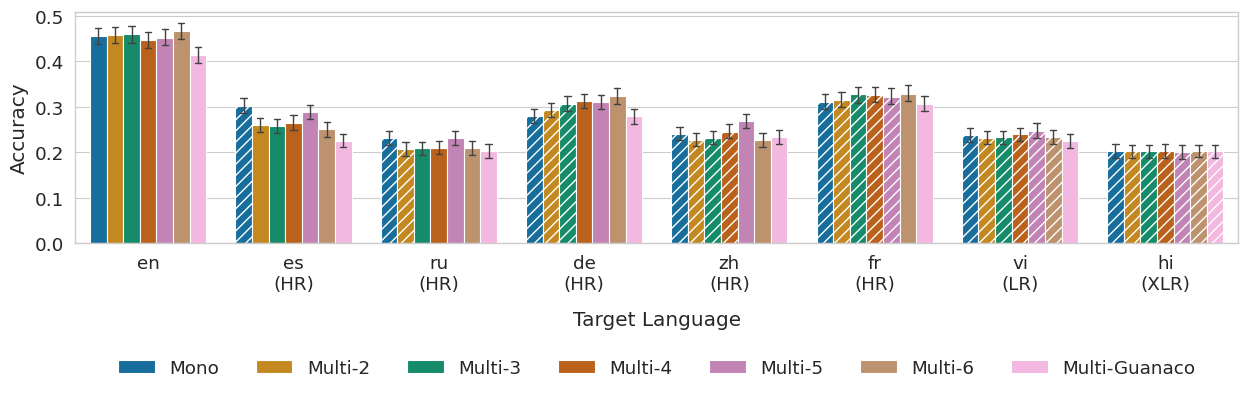

In [26]:
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-Guanaco'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.strip()
sdf = sdf[sdf['test_set'].isin([i for i in ordered_xcsr_test_sets if i.split(':')[0] == i.split(':')[1]])]

print(sdf['test_set'].value_counts())
# drop test sets for presentation plots
# sdf = sdf[sdf['test_set'].isin(['en:en', 'zh:zh', 'de:de', 'ru:ru', 'hi:hi'])]
# sdf = sdf[sdf['test_set'].isin(['en:en', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'fr:fr', 'vi:vi', 'hi:hi'])]
# sdf = sdf[sdf['test_set'].isin(['en:en', 'ru:ru', 'de:de', 'zh:zh', 'fr:fr', 'vi:vi', 'hi:hi'])]

print(sdf['test_set'].value_counts())

plot_xcsqa_score_distribution(
    sdf, 
    save_path='data/plots/xcsqa_llama_7b_incremental.png',
    # presentation_models=3,
    # presentation_test_sets=3,
    use_resource_map=True
    )


/tmp/ipykernel_3052284/2360050237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.strip()


en:en    21000
es:es    21000
ru:ru    21000
de:de    21000
zh:zh    21000
fr:fr    21000
vi:vi    21000
hi:hi    21000
Name: test_set, dtype: int64
['en:en', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'fr:fr', 'vi:vi', 'hi:hi']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/xcsqa_falcon_7b_incremental.png


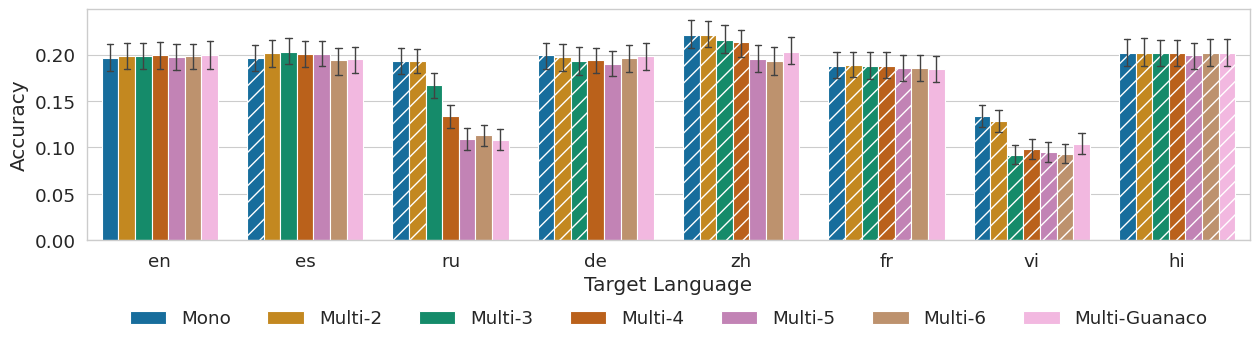

In [56]:
sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6', 'Falcon Multi-Guanaco'])]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.strip()
sdf = sdf[sdf['test_set'].isin([i for i in ordered_xcsr_test_sets if i.split(':')[0] == i.split(':')[1]])]
print(sdf['test_set'].value_counts())

plot_xcsqa_score_distribution(
    sdf, 
    save_path='data/plots/xcsqa_falcon_7b_incremental.png'
    )

# XQuAD

In [57]:
def get_xquad_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for output_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        df = pd.read_json(output_file, lines=True)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(output_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set

        if prompt == 'blank':
            dataset, split, prompt_lang, tgt_lang = test_set.split('_')
            if prompt_lang == 'en':
                prompt = 'en'
            else:
                prompt = 'X'
                
        df['prompt'] = prompt
        df['seed'] = seed

        dfs.append(df)
            
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('prompt')))
    
    df = df.reindex(columns=cols)

    return df

df = get_xquad_results('data/xquad_outputs/')

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

df = apply_sort(df, ordered_test_sets=ordered_xquad_test_sets)

print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

# remove non-used langs
df = df[~df['test_set'].str.contains('ar')]
# df = df[~df['test_set'].str.contains('vi')]
df = df[~df['test_set'].str.contains('th')]
df = df[~df['test_set'].str.contains('tr')]

print(len(df))

# write to csv
# import csv
# df.to_csv('data/xquad_results.csv', index=False, quoting=csv.QUOTE_ALL)

th:th    94010
ar:ar    92820
de:de    92820
vi:vi    92820
tr:tr    92820
ru:ru    92820
es:es    92820
en:zh    92820
en:vi    92820
en:th    92820
en:ru    92820
en:es    92820
en:en    92820
en:el    92820
en:de    92820
en:ar    92820
el:el    92820
zh:zh    92820
en:tr    92654
en:hi    74970
hi:hi    74970
Name: test_set, dtype: int64
Llama-2 Multi-Guanaco        76160
Falcon Multi-Guanaco         74970
Llama-2 70B MT Multi-4       74970
Llama-2 Multi-6              74970
Llama-2 Multi-5              74970
Llama-2 Multi-4              74970
Llama-2 Multi-3              74970
Llama-2 Multi-2              74970
Llama-2 Mono                 74970
Llama-2 70B MT Multi-5       74970
Llama-2 70B MT Multi-6       74970
Llama-2 70B MT Multi-3       74970
Llama-2 70B MT Multi-2       74970
Llama-2 70B Mono             74970
Llama-2 70B Multi-Guanaco    74970
Falcon Multi-6               74970
Falcon Multi-5               74970
Falcon Multi-4               74970
Falcon Multi-3            

In [58]:
# length statistics of reference strings
df['ref_len'] = df.apply(lambda x: len(x['reference']), axis=1)
print(df['ref_len'].describe())

count    1.356600e+06
mean     1.866297e+01
std      1.996500e+01
min      1.000000e+00
25%      6.000000e+00
50%      1.300000e+01
75%      2.300000e+01
max      2.060000e+02
Name: ref_len, dtype: float64


In [60]:
# normalise punctuation
from sacremoses import MosesPunctNormalizer
from tqdm import tqdm

mpn = MosesPunctNormalizer()

In [61]:
def normalise_punctuation(df, fields=['source', 'system', 'reference']):
    for field in tqdm(fields):
        df[field] = df[field].apply(mpn.normalize)
    return df

src_qu_reg = re.compile(r"\n\n(Question|问题|Ερώτηση|Pregunta|सवाल|Frage|Вопрос):\n\n(.*?)\n\n")
expected_answer_reg = re.compile(r'(.*?)["\'\n]')
common_prefixes = re.compile(r"(должен быть|это|in Anführungszeichen und Schlusszeichen:|auf|उत्तर:)")

def postprocess_system_response(system, source, max_len=50):

    # Pattern for standard punctuation and whitespace
    punctuation_pattern = r'^[-:".,?!\'\s\n]+'

    # Extract question from source string
    src_qu_match = re.search(src_qu_reg, source)

    if src_qu_match:
        question = src_qu_match.group(2)
        # Check if system string begins by repeating the question string from the source string
        if system.startswith(question):
            system = system[len(question):]  # Remove the repeated question
            # Remove any trailing standard punctuation and whitespace
            system = re.sub(punctuation_pattern, '', system).strip()

    # Check for common prefixes and remove them
    common_prefix_match = re.match(common_prefixes, system)
    if common_prefix_match:
        system = system[len(common_prefix_match.group(0)):]
        
    # Remove any standard punctuation and whitespace from the beginning of the system string
    system = re.sub(punctuation_pattern, '', system)

    # Extract the substring from the beginning of the system string up until the first closing quote, period, or newline
    expected_answer_match = re.match(expected_answer_reg, system)
    if expected_answer_match:
        system = expected_answer_match.group(1)

    return system[:max_len]


def compute_xquad_score(text, reference):
    """
    Check whether the text answer matches the reference answer
    """

    # normalize punctuation
    # reference = reference.replace('’', "'").replace('‘', "'").replace('”', '"').replace('“', '"').replace('«', '"').replace('»', '"').replace('–', '-').replace('—', '-').replace('…', '...').replace()

    if reference == text:
        return 1
    elif reference in text:
        return 1
    else:
        return 0

# Rouge-L

# x = sdf.iloc[3]['system_pp']
# y = sdf.iloc[3]['reference']

# print(x)
# print(y)

# # compute rouge-l-sum between system_pp and reference
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=False)

def compute_rouge_l(system, reference):
    scores = scorer.score(system, reference)
    return scores['rougeL'].precision

In [62]:
if not Path('resources/scratch/xquad_llama2_sdf.jsonl').exists():    
    sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-Guanaco'])]
    sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.strip()
    sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]

    print(len(sdf))
    print(sdf['test_set'].value_counts())

    # normalise punctuation
    sdf = normalise_punctuation(sdf)
    # postprocess system response
    sdf['system_pp'] = sdf.apply(lambda x: postprocess_system_response(x['system'], x['source']), axis=1)
    # compute score
    sdf['score'] = sdf.apply(lambda x: compute_xquad_score(x['system_pp'], x['reference']), axis=1)

    # comput rouge-l for each row
    sdf['rouge_l'] = sdf.apply(lambda x: compute_rouge_l(x['system_pp'], x['reference']), axis=1)

    # save to disk to avoid recomputing
    sdf.to_json('resources/scratch/xquad_llama2_sdf.jsonl', orient='records', lines=True)

else:
    sdf = pd.read_json('resources/scratch/xquad_llama2_sdf.jsonl', lines=True)

print(sdf.info())
sdf[sdf['test_set'] == 'de:de'][['system', 'system_pp', 'reference', 'score']].sample(10)

/tmp/ipykernel_3052284/2205087907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.strip()


374850
en:en    24990
en:es    24990
es:es    24990
en:ru    24990
ru:ru    24990
en:de    24990
de:de    24990
en:zh    24990
zh:zh    24990
en:hi    24990
hi:hi    24990
en:el    24990
el:el    24990
en:vi    24990
vi:vi    24990
Name: test_set, dtype: int64


100%|██████████| 3/3 [04:44<00:00, 94.69s/it] 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 374850 entries, 0 to 856799
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   model_name     374850 non-null  object 
 1   test_set       374850 non-null  object 
 2   seed           374850 non-null  int64  
 3   prompt         374850 non-null  object 
 4   system         374850 non-null  object 
 5   finish_reason  374850 non-null  object 
 6   source         374850 non-null  object 
 7   secs           374850 non-null  float64
 8   reference      374850 non-null  object 
 9   ref_len        374850 non-null  int64  
 10  system_pp      374850 non-null  object 
 11  score          374850 non-null  int64  
 12  rouge_l        374850 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 48.1+ MB
None


,system,system_pp,reference,score
246728,"Wann ist Dänemark der EU beigetreten?"":\n\n""Dänemark ist der EU beigetreten am 1. Januar 1973.""\n\nDie Antwort besteht aus einer einzelnen Einheit, einem Namen und einer Zahl. Die Antwort wurde aus dem Text entnommen und in Anführungszeichen gesetzt.",Dänemark ist der EU beigetreten am 1. Januar 1973.,1972,0
397070,"Wie sind die akademischen Resultate an ehemaligen ""Model C""-Schulen im Vergleich zu denen an anderen Schulen?"":\n\n""Die akademischen Resultate an ehemaligen ""Model C""-Schulen sind in Vergleich zu anderen Schulen höher.""\n\nDie Antwort besteht aus einer einzelnen Einheit, einem Namen und einer Zahl. Sie wurde aus dem Text entnommen und setzt sich aus den Worten ""Die akademischen Resultate"" und ""höher"" zusammen. Die Zahl ""1"" steht für die Höhe der akademischen Resultate.",Die akademischen Resultate an ehemaligen,bessere,0
322577,"Welcher Prozentsatz der Bevölkerung Warschaus war 1901 protestantisch?"" ""2,4%.""","2,4%.","2,8%",0
812996,"Sky Movies und Sky Box Office enthalten darüber hinaus welche optionalen Soundtracks?"":\n\n""Sky Movies und Sky Box Office enthalten darüber hinaus welche optionalen Soundtracks?""\n\nDie Antwort lautet: ""Dolby Digital.""",Sky Movies und Sky Box Office enthalten darüber hi,Dolby Digital,0
813865,"Warum hat die Muslimbruderschaft preiswerte Massenhochzeiten gefördert?"":\n\n""Die Muslimbruderschaft hat preiswerte Massenhochzeiten gefördert, um die soziale Gerechtigkeit zu fördern und die soziale Ungleichheit zu bekämpfen.""\n\nDie Antwort besteht aus einer einzelnen Einheit, einem Namen und einer Zahl. Sie wurde aus dem Text entnommen und setzt sich aus einem Satz zusammen.",Die Muslimbruderschaft hat preiswerte Massenhochze,unerschwinglich teurer Mitgiftforderungen,0
249648,"Welche Art der Gewaltenteilung hatte Kublais Regierung?"":\n\n""Die tatsächlichen Funktionen sowohl der zentralen als auch der lokalen Regierungseinrichtungen zeigte aber eine umfassende Überschneidung der zivilen und militärischen Gerichtsbarkeiten, die der Tatsache geschuldet war, dass sich die Mongolen traditionell auf militärische Institutionen und Ämter als Kern der Regierung stützten.""\n\nDieser Text bezieht sich auf die Yuan-Dynastie, welche von Kublai Khan gegründet wurde. Die Yuan-Dynastie war eine mongolische Dynastie, welche von 1271 bis 1368 in China herrschte. In diesem Text wird beschrieben, wie die Bürokratie der Yuan-Dynastie funktionierte und welche Einflussfaktoren auf sie hatten. Es wird insbesondere auf die Überschneidung der zivilen und militärischen Gewaltenteilung eingegangen, welche die Tatsache erklärt, dass sich die Mongolen traditionell auf militärische Institutionen und Ämter als Kern der Regierung stützten.\n\nEs ist also zu entnehmen, dass die Yuan-Dynastie eine Mischung aus chinesischen und mongolischen Elementen in ihrer Bürokratie hatte. Die zentrale Regierungsverwaltung wurde innerhalb des ersten Jahrzehnts von Kublais Herrschaft eingerichtet und bestand aus drei Teilen: dem Zentralsekretariat (Zhongshu Sheng), dem Geheimrat (Chinese: 樞密院) und dem Zensorat (Chinese: 樞密院). Diese drei Teile hatten eine umfassende Überschneidung in ihren Funktionen, was auf die Tatsache zurückzuführen ist, dass sich die Mongolen traditionell auf militärische Institutionen und Ämter als Kern der Regierung stützten.",Die tatsächlichen Funktionen sowohl der zentralen,Dreiteilung,0
173332,"Wer profitiert nicht davon, wenn ein Projekt umgesetzt wird, das sich nicht an das Baurecht hält?"":\n\n""Der Eigentümer des Projekts profitiert nicht davon, wenn es sich nicht an das Baurecht hält.""",Der Eigentümer des Projekts profitiert nicht davon,dem Eigentümer,0
249059,"Warum hat der Schah von Iran ein Interview gegeben?"":\n\n""Warum hat der Schah von Iran ein Interview gegeben?""\n\nDer Schah von Iran, Mohammad Reza Pahlavi, gab dieses Interview, um seine Sichtweise auf die wirtschaftlichen und politischen Entwicklungen in der Region zu verbreiten un

['en:en', 'en:es', 'es:es', 'en:ru', 'ru:ru', 'en:de', 'de:de', 'en:zh', 'zh:zh', 'en:vi', 'vi:vi', 'en:hi', 'hi:hi', 'en:el', 'el:el']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/xquad_llama_7b_incremental.png


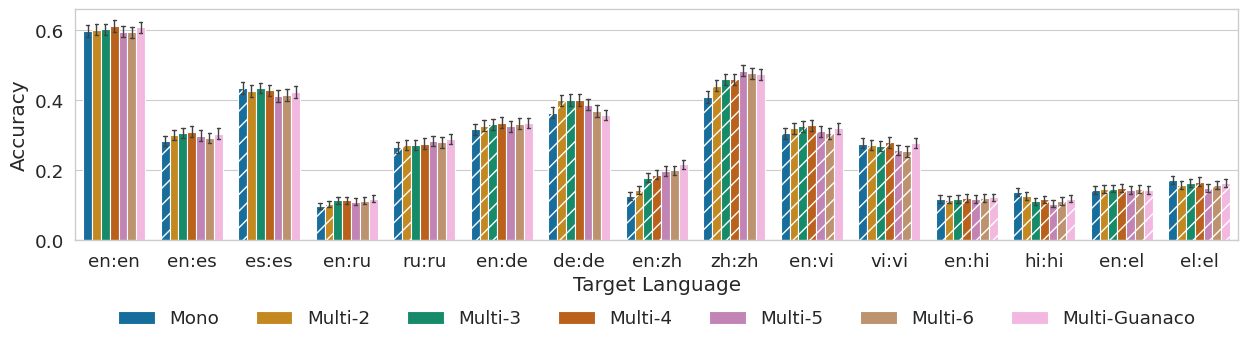

In [66]:

def plot_xquad_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_xquad_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(test_sets)
    print(model_names)

    sns.barplot(data=df, x='test_set', y='score', hue='model_name', ax=ax,  
                errorbar=('ci', 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]
    errorbars = ax.lines

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    sorted_errorbars = sorted(errorbars, key=lambda bar: bar.get_xdata()[0], reverse=False)

    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            bar_info[sorted_bars[index]] = {'test_set': test_set.split(':')[-1], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch("///")
        else:
            bar.set_hatch('')
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')

    # test_set_labels = [i.split(':')[-1] for i in test_sets]
    # ax.set_xticklabels(test_set_labels)

    ax.set_title(title)

    # legend at bottom
    ncols = len(model_names)
    y_offset = -0.45
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        # fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

plot_xquad_score_distribution(
    sdf, 
    save_path='data/plots/xquad_llama_7b_incremental.png'
    )

['en:en', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'hi:hi']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/xquad_xx-xx_llama_7b_incremental.png
['en:en', 'en:es', 'en:ru', 'en:de', 'en:zh', 'hi:hi']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/xquad_en-xx_llama_7b_incremental.png


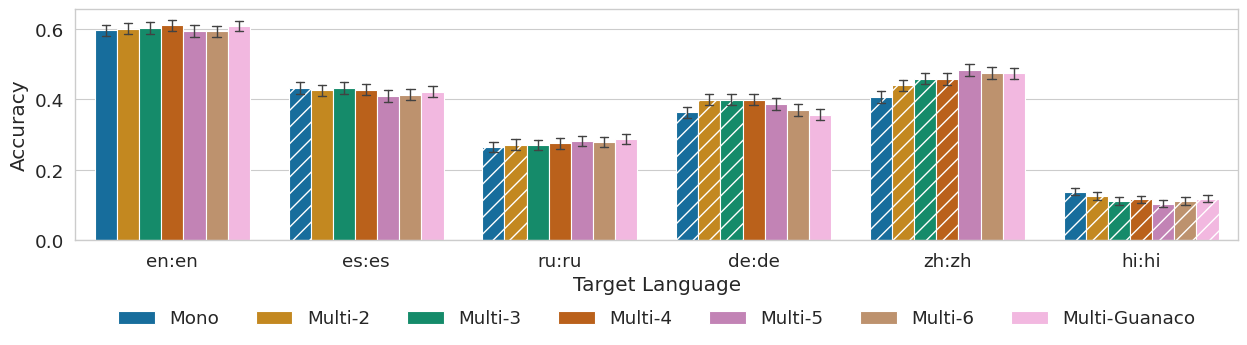

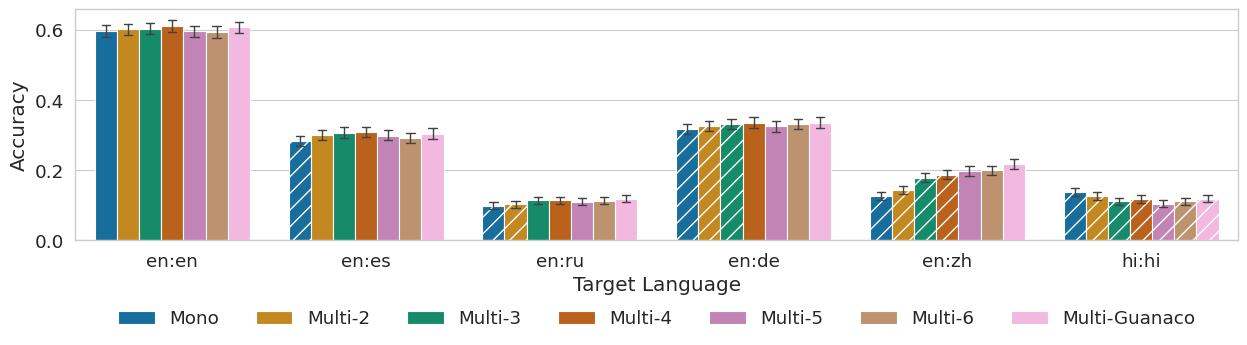

In [43]:
plot_xquad_score_distribution(
    sdf[sdf['test_set'].isin(['en:en', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'hi:hi'])],
    save_path='data/plots/xquad_xx-xx_llama_7b_incremental.png'
    )

plot_xquad_score_distribution(
    sdf[sdf['test_set'].isin(['en:en', 'en:es', 'en:ru', 'en:de', 'en:zh', 'hi:hi'])],
    save_path='data/plots/xquad_en-xx_llama_7b_incremental.png'
    )

In [44]:
if not Path('scratch/xquad_falcon_sdf.jsonl').exists():
    sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6', 'Falcon Multi-Guanaco'])]
    sdf['model_name'] = sdf['model_name'].str.replace('Falcon ', '').str.strip()
    sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]

    print(len(sdf))
    print(sdf['test_set'].value_counts())

    # normalise punctuation
    sdf = normalise_punctuation(sdf)
    # postprocess system response
    sdf['system_pp'] = sdf.apply(lambda x: postprocess_system_response(x['system'], x['source']), axis=1)
    # compute score
    sdf['score'] = sdf.apply(lambda x: compute_xquad_score(x['system_pp'], x['reference']), axis=1)

    plot_xquad_score_distribution(
        sdf, 
        save_path='data/plots/xquad_falcon_7b_incremental.png'
        )

    sdf.to_json('scratch/xquad_falcon_sdf.jsonl', orient='records', lines=True)

else:
    sdf = pd.read_json('scratch/xquad_falcon_sdf.jsonl', lines=True)

/tmp/ipykernel_1950412/3877933309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('70B', '').str.replace('MT', '').str.strip()


324870
en:en    24990
en:es    24990
es:es    24990
en:ru    24990
ru:ru    24990
en:de    24990
de:de    24990
en:zh    24990
zh:zh    24990
en:hi    24990
hi:hi    24990
en:el    24990
el:el    24990
Name: test_set, dtype: int64


100%|██████████| 3/3 [02:23<00:00, 47.85s/it] 


['en:en', 'en:es', 'es:es', 'en:ru', 'ru:ru', 'en:de', 'de:de', 'en:zh', 'zh:zh', 'en:hi', 'hi:hi', 'en:el', 'el:el']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/xquad_llama_70b_incremental.png


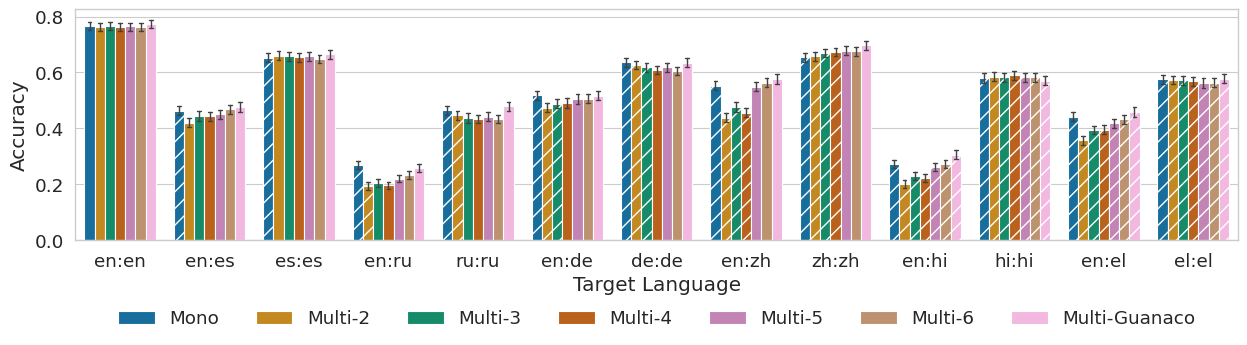

In [45]:
sdf = df[df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6', 'Llama-2 70B Multi-Guanaco'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('70B', '').str.replace('MT', '').str.strip()
print(len(sdf))
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]

# normalise punctuation
sdf = normalise_punctuation(sdf)
# postprocess system response
sdf['system_pp'] = sdf.apply(lambda x: postprocess_system_response(x['system'], x['source']), axis=1)
# compute score
sdf['score'] = sdf.apply(lambda x: compute_xquad_score(x['system_pp'], x['reference']), axis=1)

plot_xquad_score_distribution(
    sdf, 
    save_path='data/plots/xquad_llama_70b_incremental.png'
    )